# Debit Card Fraud Detection

# Import Dependencies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, fcluster

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Data Profiling

In [2]:
df = pd.read_csv("/Users/raghav/Downloads/bank_transactions_data_2.csv")
df.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81              1   
1           68             Doctor                  141              1   
2           19            Student                   56              1   
3           26            Student                   25              1   
4           26            Student                  198              1   

   AccountBalance PreviousTransactionDate  
0         5112.21     2024-11-04 08:08:08  
1        13758.91     2024-11-04 08:09:35  
2         1122.35     2024-11-04 08:07:04  
3         8569.06     2024-11-04 08:09:06  
4         7429.40     2024-11-04 08:06:39

Remove Customer Demographic Data

In [3]:
demographic_columns = ['CustomerAge', 'CustomerOccupation']
df = df.drop(columns=demographic_columns, errors='ignore')
df.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   TransactionDuration  LoginAttempts  AccountBalance PreviousTransactionDate  
0                   81              1         5112.21     2024-11-04 08:08:08  
1                  141              1        13758.91     2024-11-04 08:09:35  
2                   56              1         1122.35     2024-11-04 08:07:04  
3                   25              1         8569.06     2024-11-04 08:09:06  
4                  198              1         7429.40     2024-11-04 08:06:39

Filtering the transactions made using Debit card

In [4]:
debit_transactions = df[df['TransactionType'] == 'Debit']
data = debit_transactions
data.head()

TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
5      TX000006   AC00393              92.15  2023-04-03 17:15:01   

  TransactionType       Location DeviceID      IP Address MerchantID Channel  \
0           Debit      San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit        Houston  D000051     13.149.61.4       M052     ATM   
2           Debit           Mesa  D000235  215.97.143.157       M009  Online   
3           Debit        Raleigh  D000187  200.13.225.150       M002  Online   
5           Debit  Oklahoma City  D000579  117.67.192.211       M054     ATM   

   TransactionDuration  LoginAttempts  AccountBalance PreviousTransactionDate  
0                   81              1         5112.21     2024-11-04 08:08:08  
1                  141              1        13758.91     2024-11-04 08:09:35  
2                   56              1         1122.35     2024-11-04 08:07:04  
3                   25              1         8569.06     2024-11-04 08:09:06  
5                  172              1          781.68     2024-11-04 08:06:36

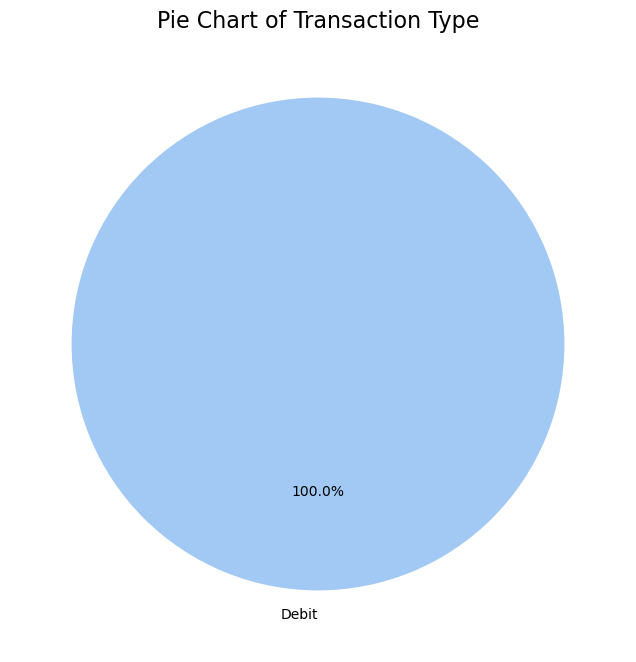

In [5]:
# Pie chart for 'TransactionType'
plt.figure(figsize=(8, 8))
data['TransactionType'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Pie Chart of Transaction Type', fontsize=16)
plt.ylabel('')  # Remove default y-axis label
plt.show()

In [32]:
model_data_input_path = '/Users/raghav/Desktop/Apexon/DC_fraud_Detection/input_data.csv'
data.to_csv(model_data_input_path, index=False)

Data Preprocessing

In [9]:
data = pd.read_csv("/Users/raghav/Downloads/input_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1944 entries, 0 to 1943
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            1944 non-null   object 
 1   AccountID                1944 non-null   object 
 2   TransactionAmount        1944 non-null   float64
 3   TransactionDate          1944 non-null   object 
 4   TransactionType          1944 non-null   object 
 5   Location                 1944 non-null   object 
 6   DeviceID                 1944 non-null   object 
 7   IP Address               1944 non-null   object 
 8   MerchantID               1944 non-null   object 
 9   Channel                  1944 non-null   object 
 10  TransactionDuration      1944 non-null   int64  
 11  LoginAttempts            1944 non-null   int64  
 12  AccountBalance           1944 non-null   float64
 13  PreviousTransactionDate  1944 non-null   object 
dtypes: float64(2), int64(2),

In [10]:
data.describe()

TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance
count        1944.000000          1944.000000    1944.000000     1944.000000
mean          294.991255           119.716049       1.118827     5074.849805
std           292.527512            70.513970       0.585267     3867.504758
min             0.260000            10.000000       1.000000      101.250000
25%            83.137500            63.000000       1.000000     1482.977500
50%           205.140000           114.000000       1.000000     4710.125000
75%           407.785000           162.000000       1.000000     7630.422500
max          1919.110000           300.000000       5.000000    14977.990000

In [11]:
print("Missing values: \n", data.isnull().sum())

# Fill or drop missing values (example: fill missing numeric columns with median)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Handle categorical data (example: fill missing with mode)
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Convert date columns to datetime format (if applicable)
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])

# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Drop columns with too many missing values (optional)
numeric_data = numeric_data.dropna(axis=1, thresh=len(numeric_data) * 0.5)  # Keep columns with >50% non-NaN values

# Fill remaining missing values with median (optional)
numeric_data = numeric_data.fillna(numeric_data.median())

Missing values: 
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64


# Exploratory Data Analysis

## 1. Univariant Analysis

Correlation Matrix:
                     TransactionAmount  TransactionDuration  LoginAttempts  \
TransactionAmount             1.000000             0.011932      -0.014599   
TransactionDuration           0.011932             1.000000       0.033517   
LoginAttempts                -0.014599             0.033517       1.000000   
AccountBalance               -0.028185            -0.003430       0.020831   

                     AccountBalance  
TransactionAmount         -0.028185  
TransactionDuration       -0.003430  
LoginAttempts              0.020831  
AccountBalance             1.000000  


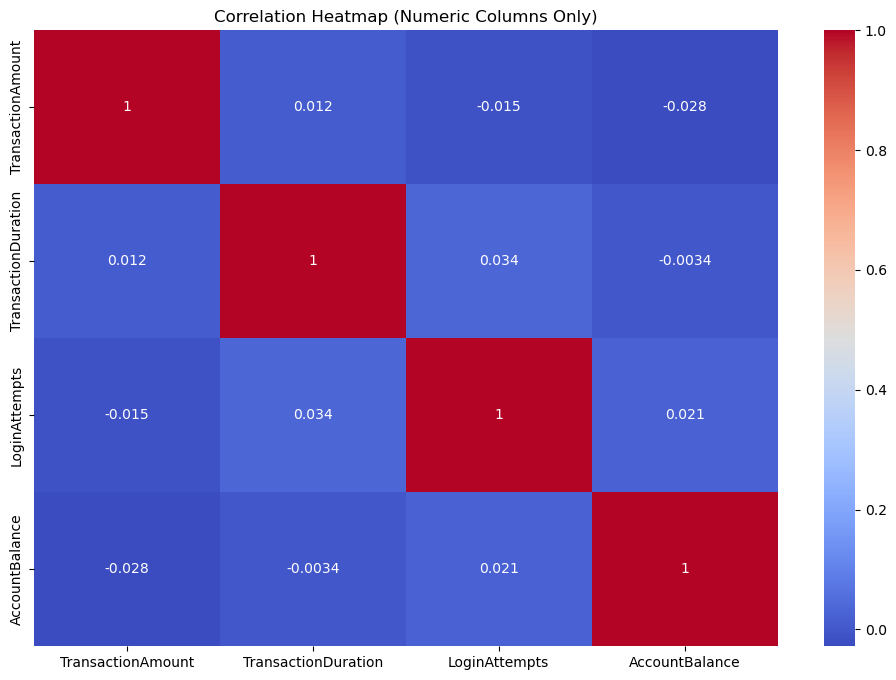

In [12]:
# Compute the correlation matrix for numeric data only
correlation_matrix = numeric_data.corr()

# Verify the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numeric Columns Only)')
plt.show()

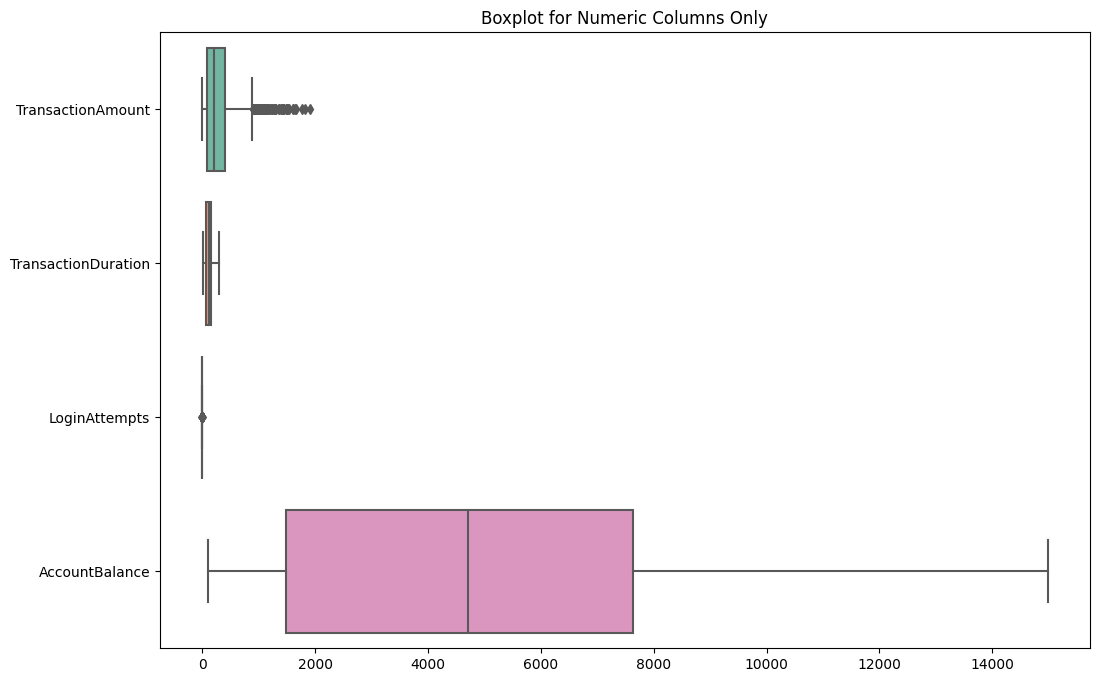

In [51]:
# Additional: Boxplot for numeric columns only
plt.figure(figsize=(12, 8))
sns.boxplot(data=numeric_data, orient="h", palette="Set2")
plt.title('Boxplot for Numeric Columns Only')
plt.show()

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


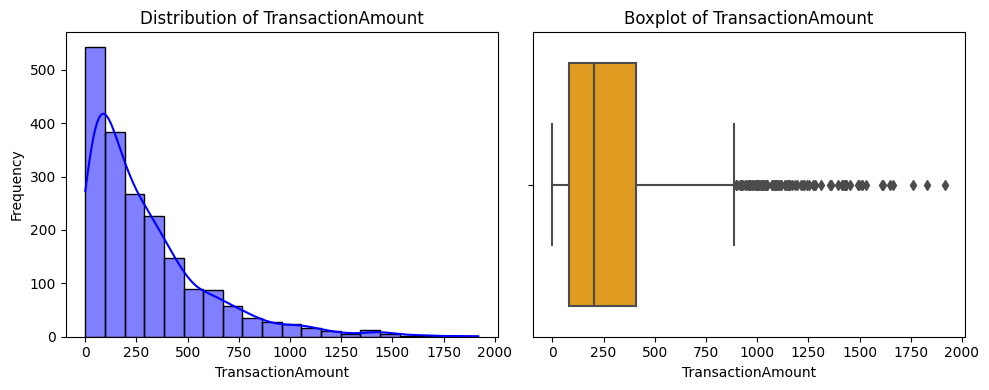

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


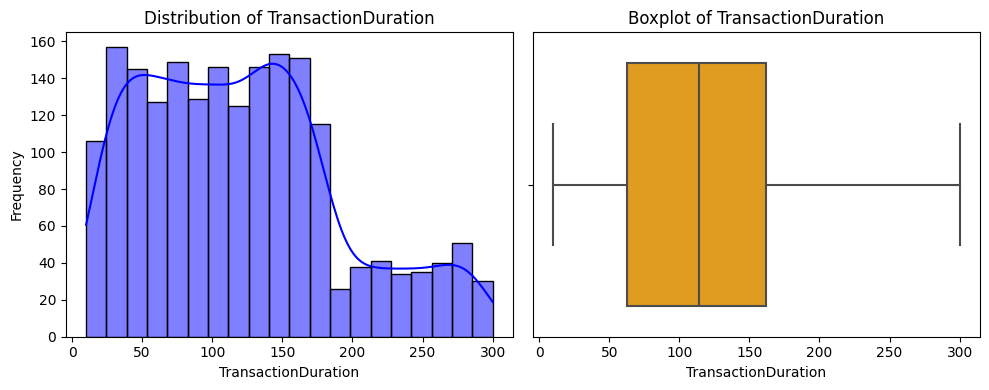

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


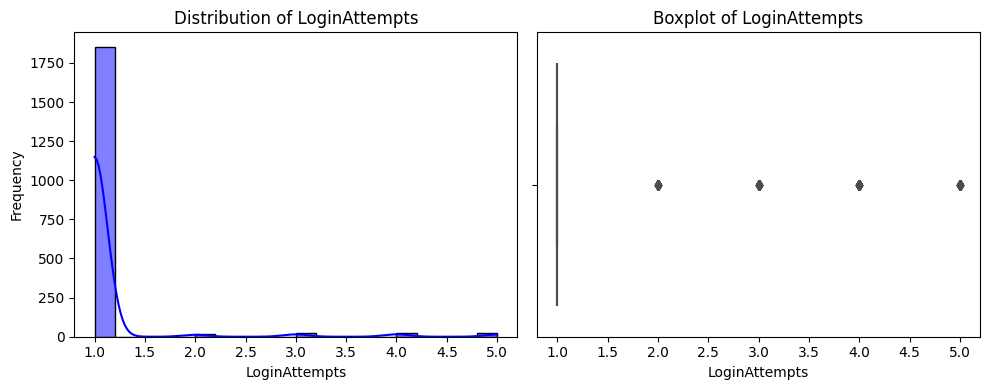

/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


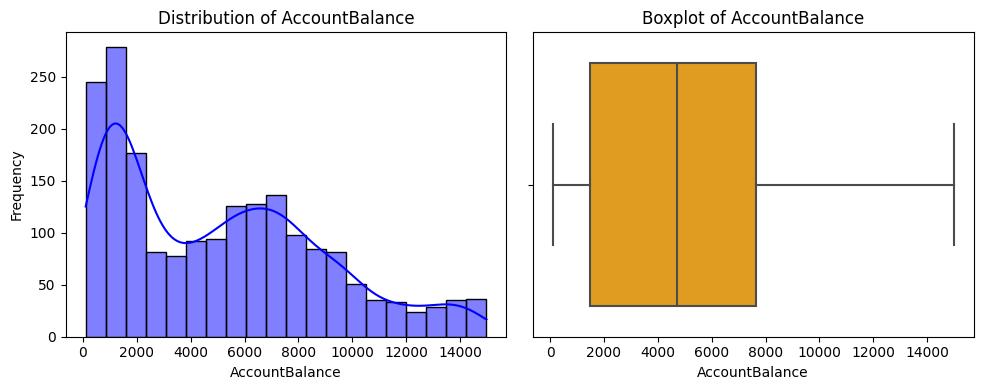

In [53]:
# Step 1: Identify numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Plot univariate graphs
for col in numeric_cols:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[col], kde=True, bins=20, color='blue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col], color='orange')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


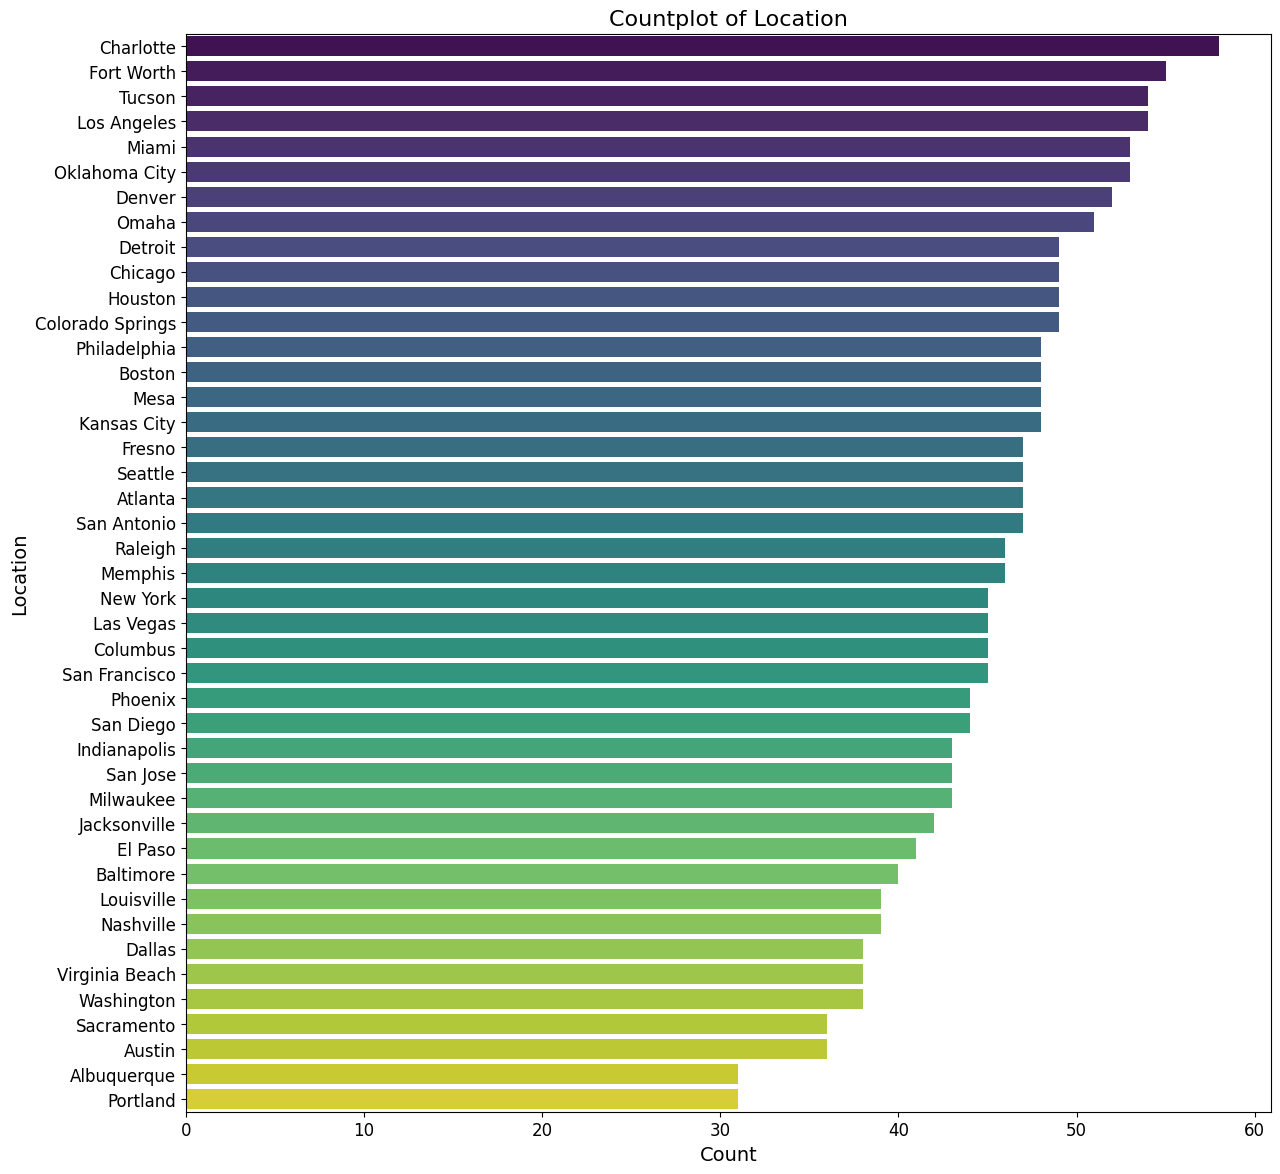

In [55]:
# Countplot for 'Location'
plt.figure(figsize=(14, 14))
sns.countplot(y=data['Location'], order=data['Location'].value_counts().index, palette='viridis')
plt.title('Countplot of Location', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Location', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

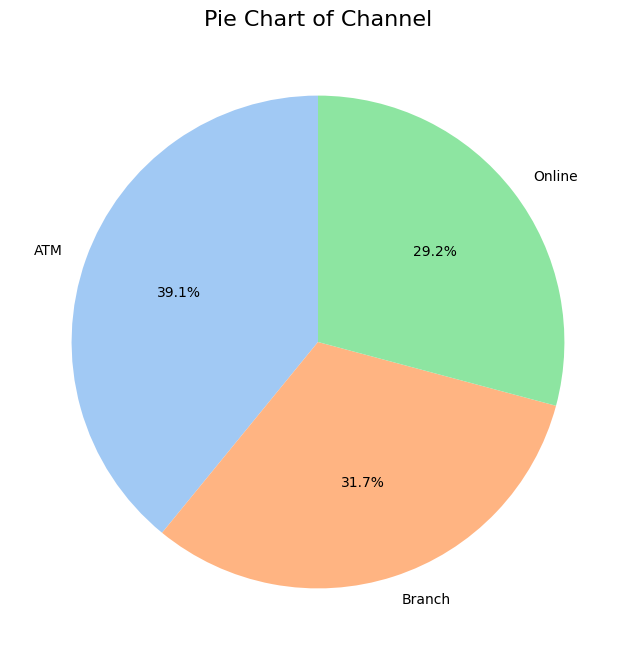

In [58]:
# Pie chart for 'Channel'
plt.figure(figsize=(8, 8))
data['Channel'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Pie Chart of Channel', fontsize=16)
plt.ylabel('')  # Remove default y-axis label
plt.show()


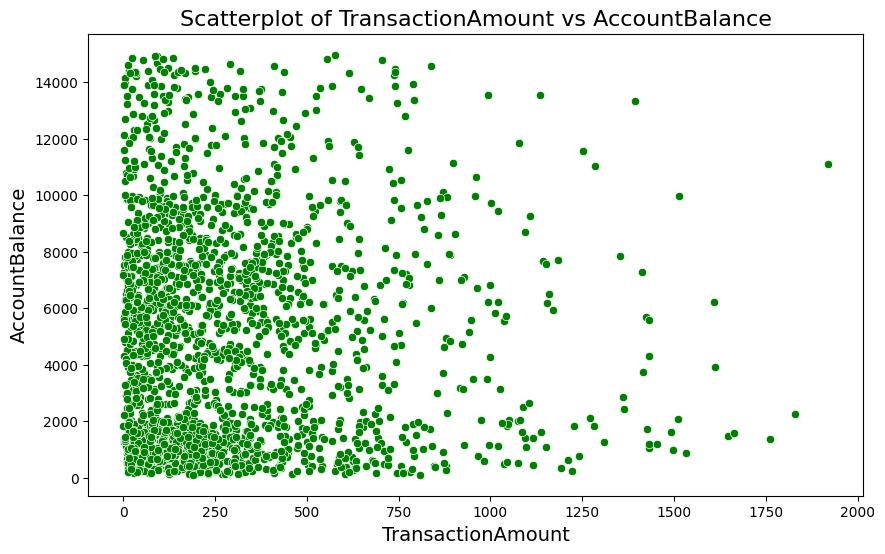

In [64]:
# Scatterplot for any two numeric variables (e.g., 'TransactionAmount' vs 'AccountBalance')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['TransactionAmount'], y=data['AccountBalance'], color='green')
plt.title('Scatterplot of TransactionAmount vs AccountBalance', fontsize=16)
plt.xlabel('TransactionAmount', fontsize=14)
plt.ylabel('AccountBalance', fontsize=14)
plt.show()

## Bivariate Analysis

In [65]:
# Define numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
categorical_cols = ['TransactionType', 'Location', 'Channel', 'MerchantID']

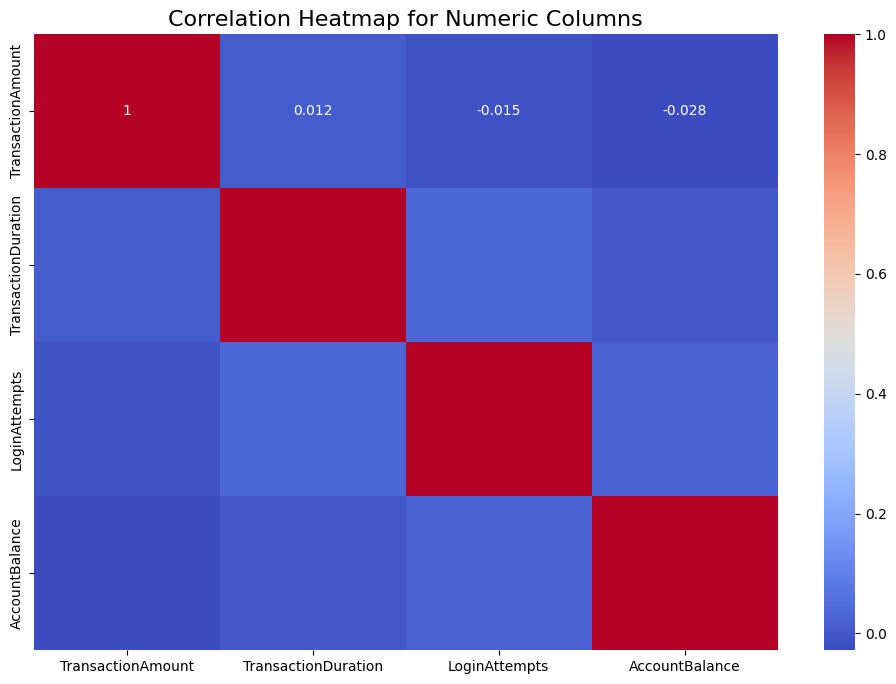

In [66]:
# 1. Correlation Heatmap for Numeric Columns
plt.figure(figsize=(12, 8))
sns.heatmap(debit_transactions[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Numeric Columns', fontsize=16)
plt.show()

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


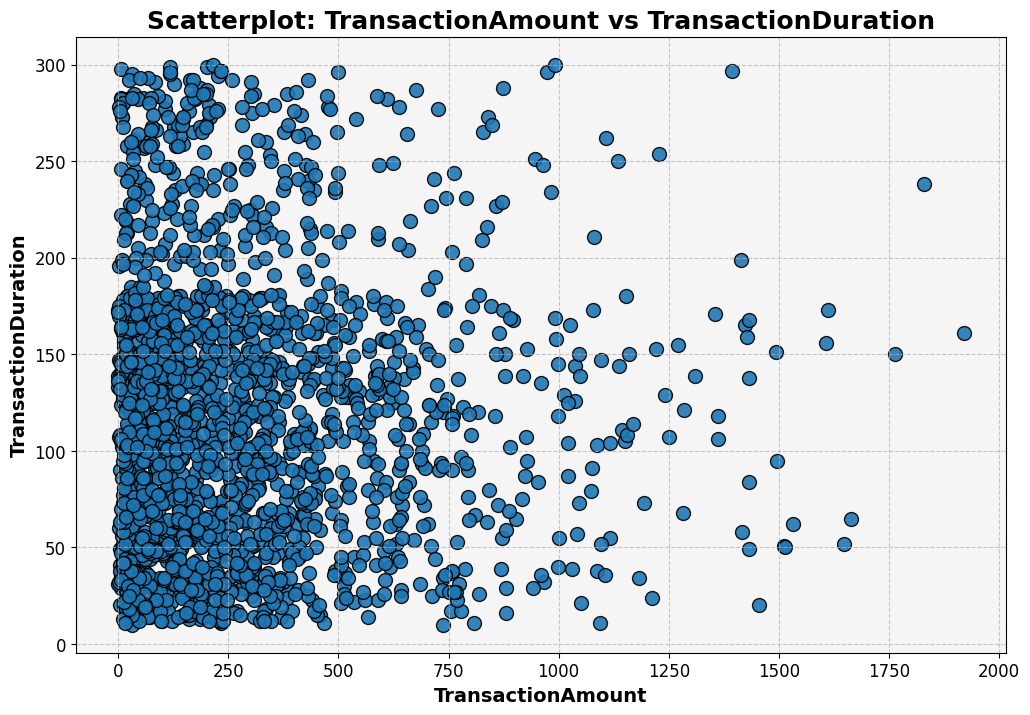

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


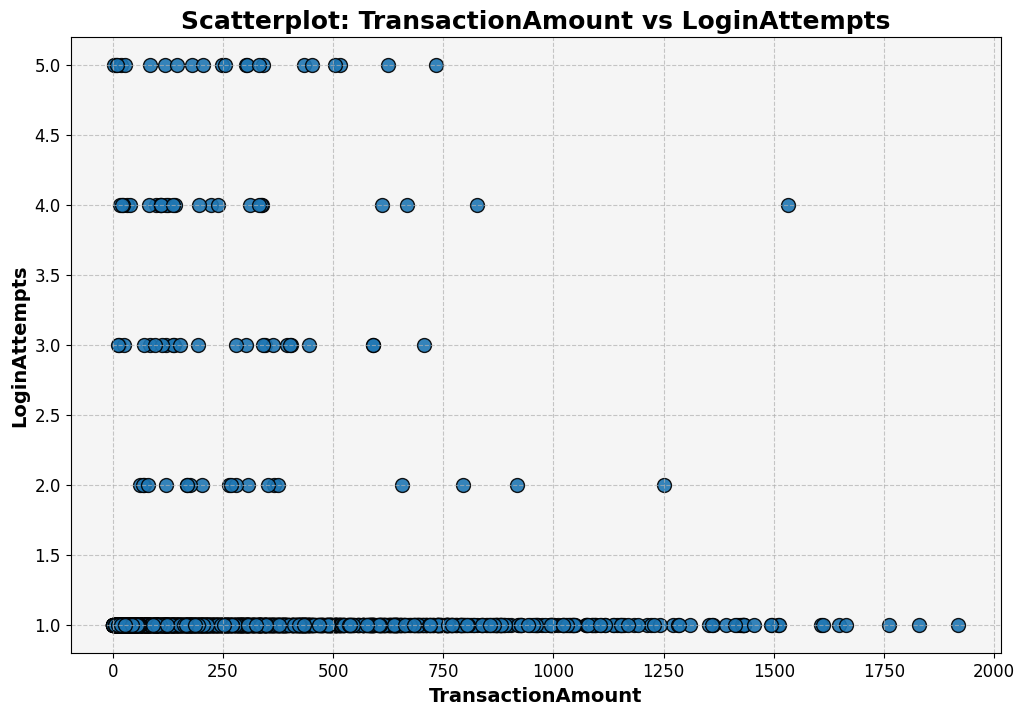

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


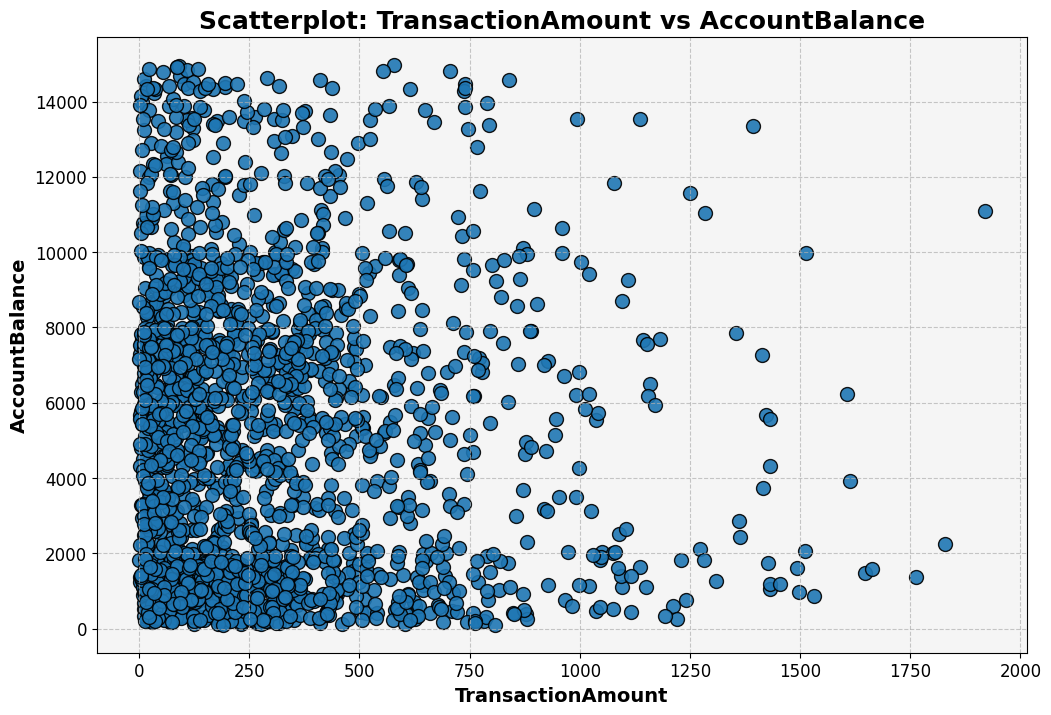

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


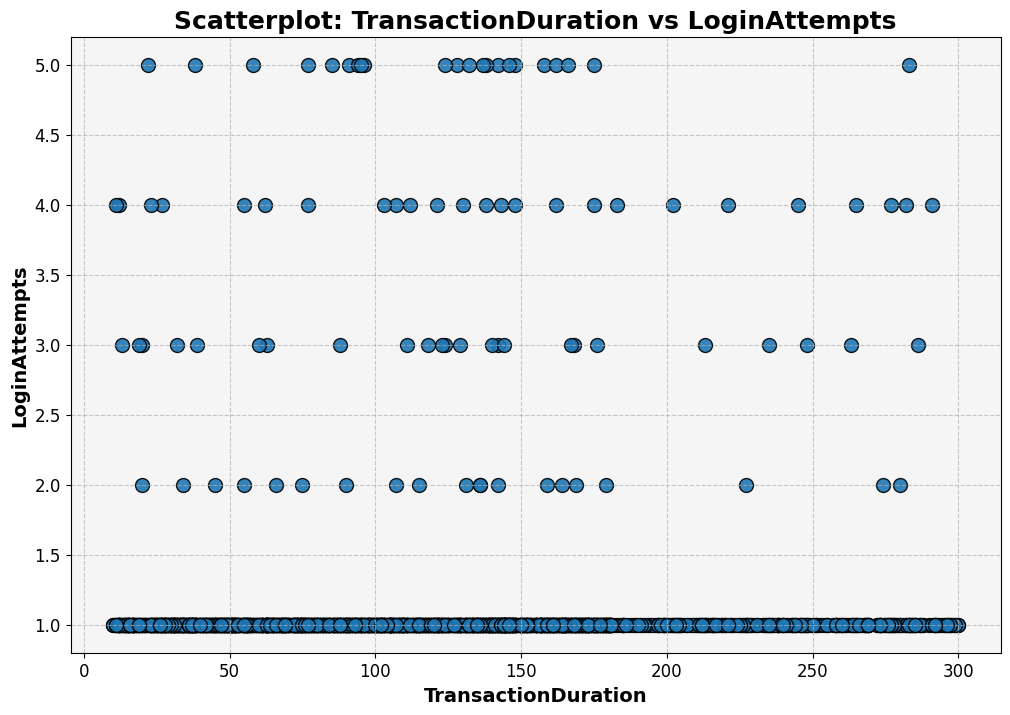

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


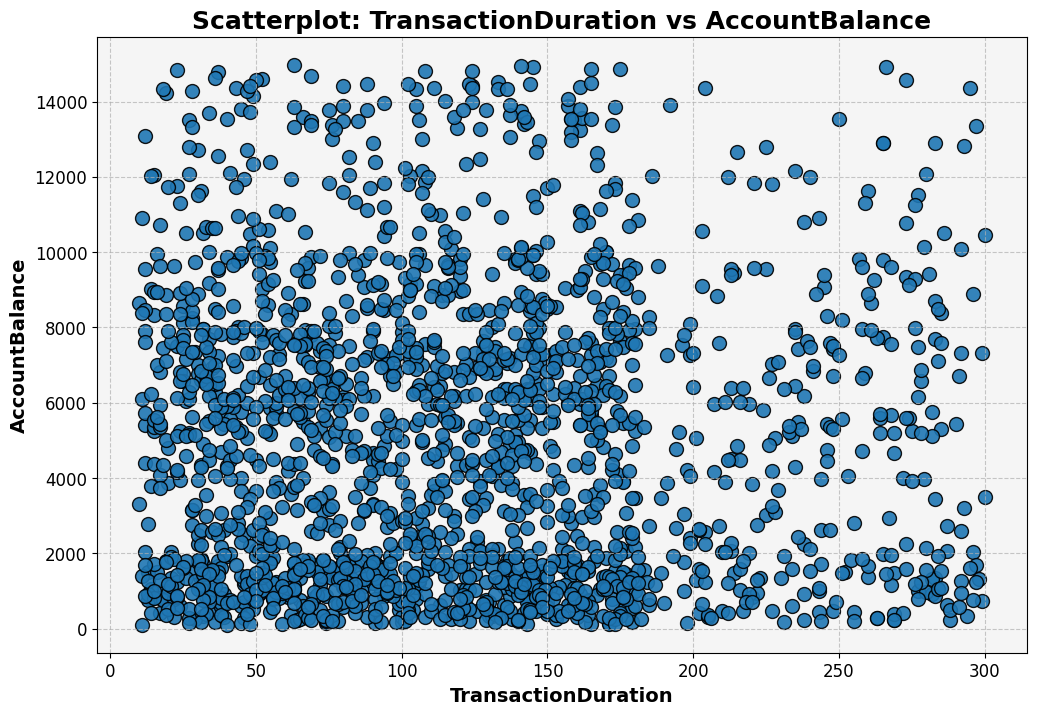

/var/folders/4k/ppk1bjp50_33bm8_tl6w0z4h0000gn/T/ipykernel_61814/280201277.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2],


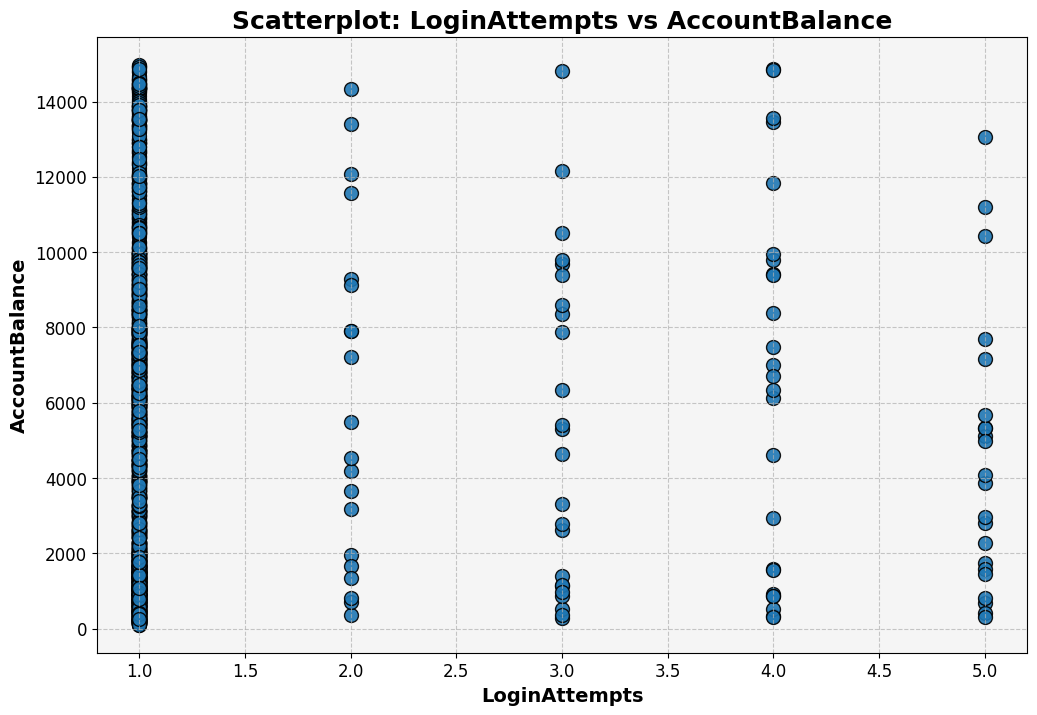

In [71]:
# 2. Scatterplots for Numeric vs Numeric with enhanced design
for i, col1 in enumerate(numeric_cols):
    for col2 in numeric_cols[i+1:]:
        plt.figure(figsize=(12, 8))
        
        # Use a vibrant color palette
        sns.scatterplot(x=debit_transactions[col1], y=debit_transactions[col2], 
                        alpha=0.9, # Less transparency for vibrant color
                        palette='viridis', # Vibrant color palette
                        s=100, # Increase dot size for better visibility
                        edgecolor='black', # Adding black edge around dots for contrast
                        linewidth=1) # Make edges of the points clearer
        
        # Titles and labels
        plt.title(f'Scatterplot: {col1} vs {col2}', fontsize=18, fontweight='bold')
        plt.xlabel(col1, fontsize=14, fontweight='bold')
        plt.ylabel(col2, fontsize=14, fontweight='bold')
        
        # Enhance gridlines and background
        plt.grid(True, linestyle='--', alpha=0.7)  # Dashed grid lines with low opacity
        plt.gca().set_facecolor('whitesmoke')  # Light background color for clarity

        # Increase font size of ticks for better readability
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        
        # Save the plot with high resolution (DPI)
        plt.savefig(f"scatterplot_{col1}_vs_{col2}.png", dpi=300)  # High DPI for quality
        
        # Show plot
        plt.show()

## MultiVariate Analysis

In [74]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

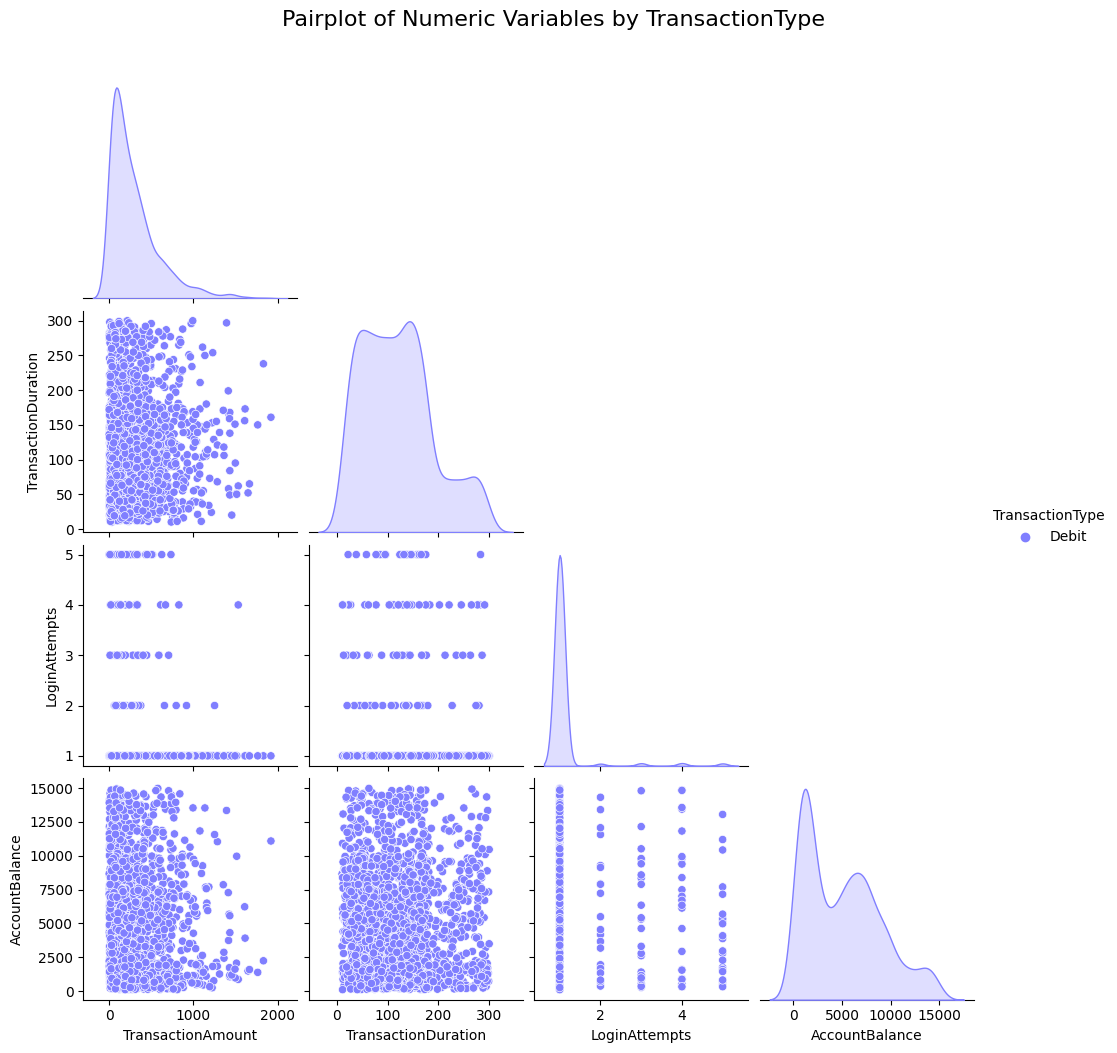

In [114]:
# 1. Multivariate Pairplot (Numeric variables colored by TransactionType)
sns.pairplot(data, vars=numeric_cols, hue='TransactionType', palette='cool', corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Numeric Variables by TransactionType', fontsize=16, y=1.05)
plt.show()

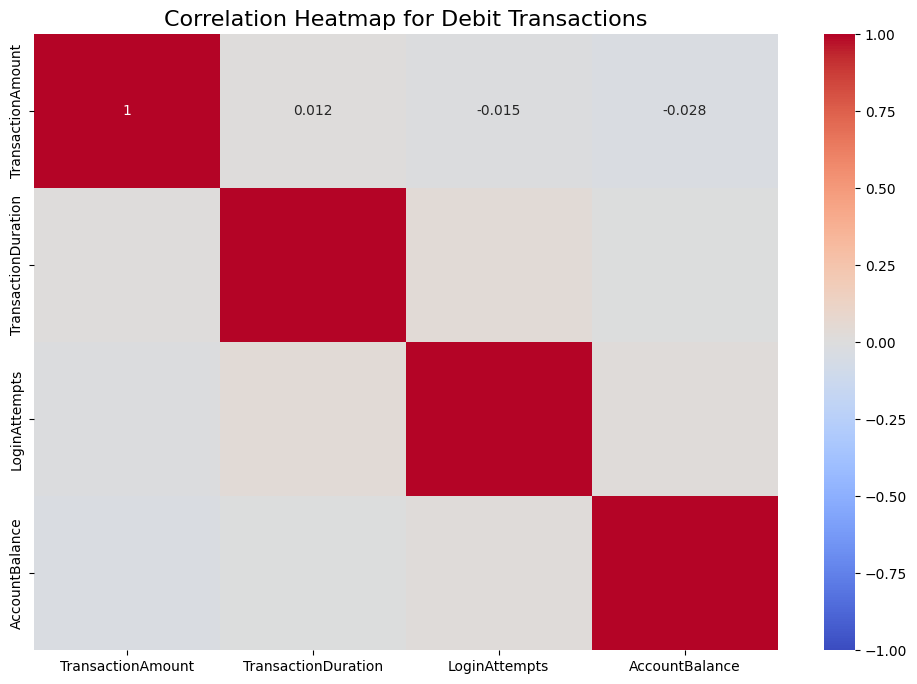

In [79]:
# 2. Heatmap of Numeric Correlations grouped by TransactionType
for trans_type in data['TransactionType'].unique():
    subset = data[data['TransactionType'] == trans_type]
    plt.figure(figsize=(12, 8))
    sns.heatmap(subset[numeric_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap for {trans_type} Transactions', fontsize=16)
    plt.show()

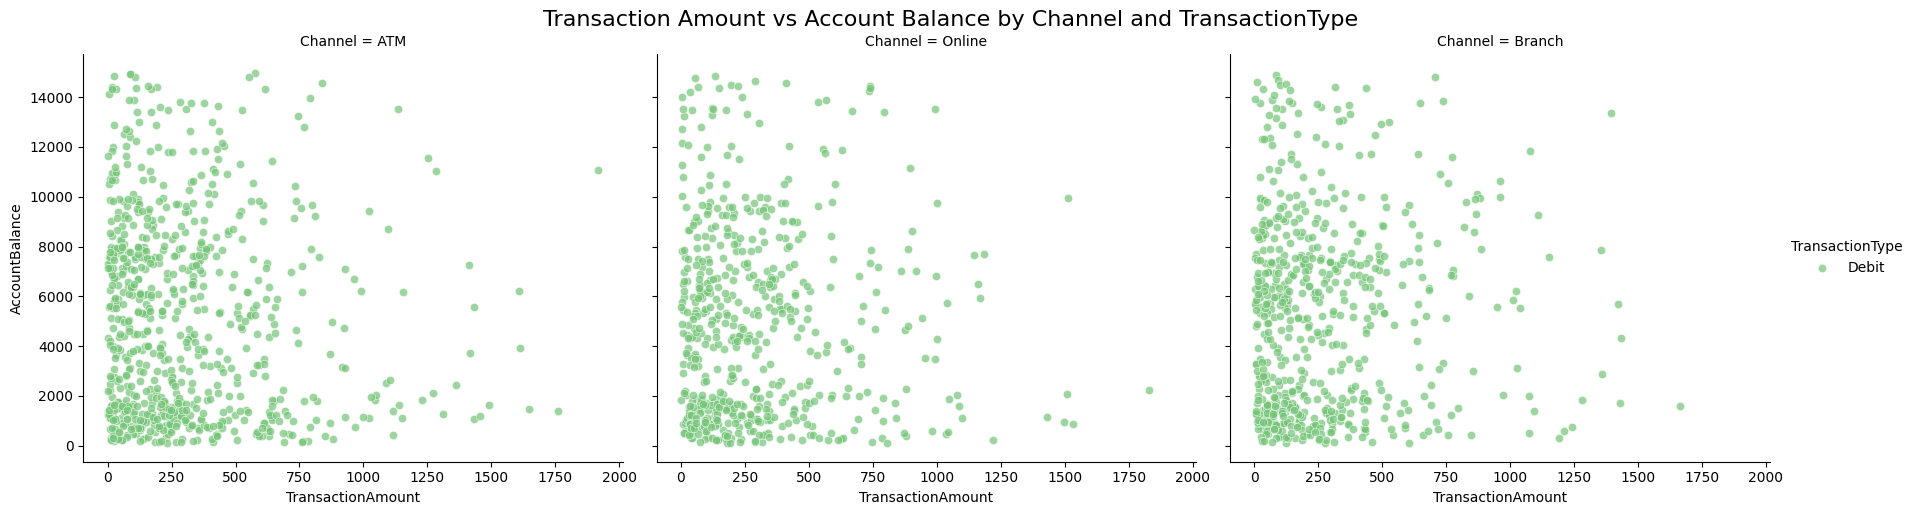

In [112]:
# 3. FacetGrid: Scatterplot of Transaction Amount vs Account Balance by Channel
g = sns.FacetGrid(data, col="Channel", hue="TransactionType", palette="Greens", height=5, aspect=1.2)
g.map(sns.scatterplot, "TransactionAmount", "AccountBalance", alpha=0.7)
g.add_legend()
g.fig.suptitle('Transaction Amount vs Account Balance by Channel and TransactionType', fontsize=16, y=1.02)
plt.show()

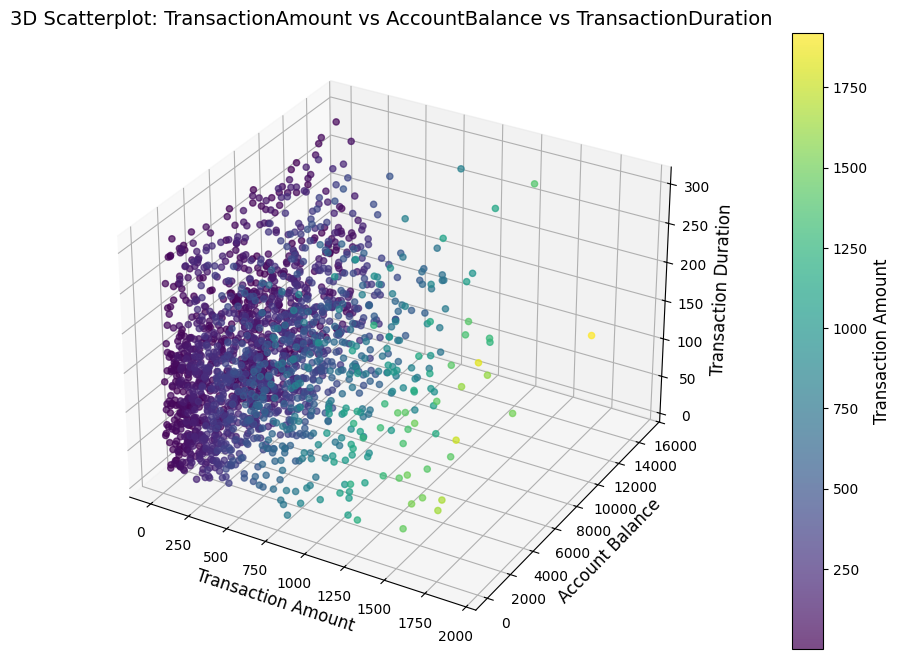

In [111]:
# 4. 3D Scatterplot: Visualize three numeric variables
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    data['TransactionAmount'], 
    data['AccountBalance'], 
    data['TransactionDuration'], 
    c=data['TransactionAmount'], 
    cmap='viridis', 
    alpha=0.7
)
ax.set_xlabel('Transaction Amount', fontsize=12)
ax.set_ylabel('Account Balance', fontsize=12)
ax.set_zlabel('Transaction Duration', fontsize=12)
plt.title('3D Scatterplot: TransactionAmount vs AccountBalance vs TransactionDuration', fontsize=14)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Transaction Amount', fontsize=12)
plt.show()

## Fraud Detection

In [14]:
train_data, test_data = train_test_split(data, test_size=0.1, random_state = 42)

print("Training data size:", len(train_data))
print("Test data size:", len(test_data))

Training data size: 1749
Test data size: 195


In [34]:
test_data.head()
output_path = '/Users/raghav/Desktop/Apexon/DC_fraud_Detection/potential_fraudulent_transactions1.csv'
sorted_data.to_csv(output_path, index=False)
print(f"Sorted data saved to {output_path}")

TransactionID AccountID  TransactionAmount      TransactionDate  \
1610      TX002078   AC00144             125.83  2023-05-29 17:14:03   
1402      TX001818   AC00222             918.95  2023-05-01 16:43:40   
1718      TX002219   AC00248             590.68  2023-09-25 16:56:21   
1054      TX001373   AC00116             356.56  2023-10-09 17:23:21   
307       TX000396   AC00411             826.23  2023-05-31 16:25:19   

     TransactionType          Location DeviceID       IP Address MerchantID  \
1610           Debit       Los Angeles  D000608  113.137.153.101       M001   
1402           Debit           Seattle  D000563     106.244.1.47       M026   
1718           Debit        Washington  D000249   179.43.245.131       M037   
1054           Debit          New York  D000399    157.130.28.27       M100   
307            Debit  Colorado Springs  D000056   153.178.166.93       M042   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
1610     ATM                  138              1         6109.86   
1402  Online                  139              1         7006.46   
1718  Branch                   23              1          852.20   
1054  Online                   52              1         2485.73   
307      ATM                  209              1         7580.59   

     PreviousTransactionDate  
1610     2024-11-04 08:11:30  
1402     2024-11-04 08:07:44  
1718     2024-11-04 08:09:15  
1054     2024-11-04 08:11:57  
307      2024-11-04 08:07:32

#### Use the below line of code to change to the test_data and run the code:

In [17]:
data = train_data

In [18]:

# Preprocessing: Handle datetime columns
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'],format='%Y-%m-%d %H:%M:%S')
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'],format='%Y-%m-%d %H:%M:%S')
data['TimeSinceLastTransaction'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds()

# Identify numeric and categorical columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'TimeSinceLastTransaction']
categorical_cols = ['TransactionType', 'Location', 'Channel']

# Normalize numeric columns
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols)

# One-hot encode categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')  # Avoid dummy variable trap
categorical_encoded = pd.DataFrame(encoder.fit_transform(data[categorical_cols]), 
                                   columns=encoder.get_feature_names_out(categorical_cols))

# Combine preprocessed data
processed_data = pd.concat([numeric_scaled, categorical_encoded], axis=1)

# Descriptive Statistics
print("Descriptive Statistics:")
print(data[numeric_cols].describe())

# Initialize Fraud column
data['Fraud'] = False

Descriptive Statistics:
       TransactionAmount  TransactionDuration  LoginAttempts  AccountBalance  \
count        1749.000000          1749.000000    1749.000000     1749.000000   
mean          295.256387           120.080617       1.113208     5014.436346   
std           291.657000            70.816970       0.574827     3835.475829   
min             0.260000            10.000000       1.000000      101.250000   
25%            82.170000            63.000000       1.000000     1447.260000   
50%           206.460000           115.000000       1.000000     4656.940000   
75%           409.590000           164.000000       1.000000     7574.450000   
max          1919.110000           300.000000       5.000000    14977.990000   

       TimeSinceLastTransaction  
count              1.749000e+03  
mean              -4.225570e+07  
std                9.219681e+06  
min               -5.803261e+07  
25%               -5.050926e+07  
50%               -4.204177e+07  
75%              

### Model 1: K-means Clustering
Identifies anomalies based on distance from centroids.

In [21]:
pip install --upgrade scikit-learn threadpoolctl

Note: you may need to restart the kernel to use updated packages.


Threshold: 2.941145404041934
Fraud Summary:
KMeans_Fraud
False    1736
True       13
Name: count, dtype: int64
      TransactionAmount  KMeans_Distance  KMeans_Fraud
704              354.76         2.439124         False
818               13.48         2.704401         False
1470              52.87         0.976826         False
1185             292.95         1.087624         False
115               28.53         0.646290         False


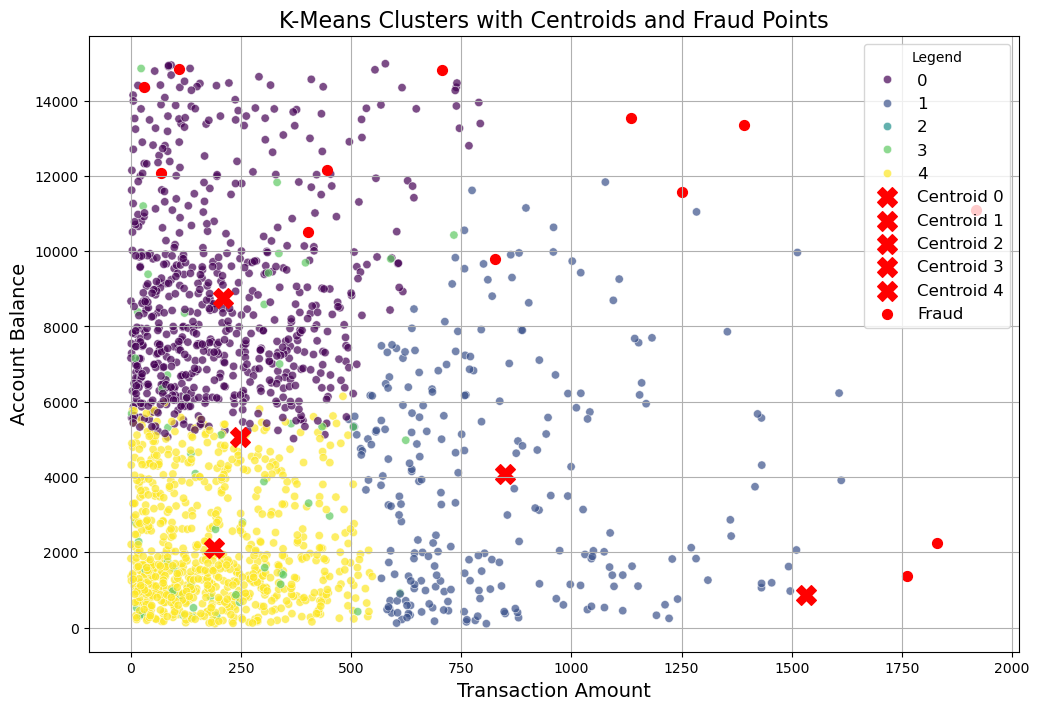

In [19]:
# Identify numeric columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

# Assuming 'data' is already defined and contains the necessary columns
# Standardize numeric columns for clustering
scaler = StandardScaler()
numeric_scaled = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols)

# Perform K-Means clustering
n_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans_labels = kmeans.fit_predict(numeric_scaled)
data['KMeans_Cluster'] = kmeans_labels

# Calculate distances from centroids
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(numeric_scaled.values - centroids[kmeans_labels], axis=1)
data['KMeans_Distance'] = distances

# Set threshold: Mean + 3 * Standard Deviation
threshold = distances.mean() + 3 * distances.std()
data['KMeans_Fraud'] = distances > threshold

# Summary of flagged anomalies
fraud_summary = data['KMeans_Fraud'].value_counts()
print(f"Threshold: {threshold}")
print(f"Fraud Summary:\n{fraud_summary}")
print(data[['TransactionAmount', 'KMeans_Distance', 'KMeans_Fraud']].head())

# Calculate centroids and scale them back to the original feature space
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Scatterplot for two features with clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['KMeans_Cluster'],
    palette='viridis',
    alpha=0.7,
    legend='full'
)

# Overlay centroids on the scatterplot
for i, centroid in enumerate(centroids_original):
    plt.scatter(
        centroid[numeric_cols.index('TransactionAmount')],
        centroid[numeric_cols.index('AccountBalance')],
        color='red',
        marker='X',
        s=200,
        label=f'Centroid {i}'
    )

# Highlight fraud points
fraud_points = data[data['KMeans_Fraud']]
plt.scatter(
    fraud_points['TransactionAmount'],
    fraud_points['AccountBalance'],
    color='red',
    marker='o',
    s=50,
    label='Fraud'
)

plt.title('K-Means Clusters with Centroids and Fraud Points', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Legend', fontsize=12)
plt.grid(True)
plt.show()

In [20]:
# Print summary of fraud points
total_fraud_points = data['Fraud'].sum()
print(f"Total Fraudulent Transactions Detected (Using K Means clustering): {total_fraud_points}")

# Display fraud transactions
print("Fraudulent Transactions Detected:")
fraud_points

Total Fraudulent Transactions Detected (Using K Means clustering): 0
Fraudulent Transactions Detected:


TransactionID AccountID  TransactionAmount     TransactionDate  \
173       TX000232   AC00430             705.60 2023-02-20 18:41:43   
602       TX000773   AC00093             827.14 2023-01-17 17:25:13   
365       TX000467   AC00063             445.41 2023-11-20 16:27:31   
1385      TX001797   AC00146            1135.80 2023-09-06 16:03:15   
506       TX000654   AC00423            1919.11 2023-06-27 17:48:25   
1010      TX001315   AC00452              30.87 2023-07-12 16:50:42   
291       TX000376   AC00316            1392.54 2023-11-20 16:51:14   
1259      TX001635   AC00358            1762.28 2023-10-06 16:05:34   
260       TX000341   AC00107            1830.00 2023-03-01 16:31:58   
1807      TX002331   AC00415              69.38 2023-01-11 16:09:36   
1665      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
1246      TX001619   AC00305             108.75 2023-10-17 16:09:20   
1895      TX002446   AC00439             403.01 2023-09-04 17:32:35   

     TransactionType     Location DeviceID       IP Address MerchantID  \
173            Debit      Phoenix  D000103    205.45.234.42       M071   
602            Debit      El Paso  D000645   215.97.143.157       M018   
365            Debit       Fresno  D000039    185.23.87.107       M015   
1385           Debit    San Diego  D000485     16.131.3.140       M004   
506            Debit     Portland  D000191  207.157.126.125       M033   
1010           Debit       Fresno  D000015    34.92.221.183       M025   
291            Debit      El Paso  D000113    63.67.150.226       M013   
1259           Debit      Memphis  D000008    26.105.49.129       M066   
260            Debit  San Antonio  D000436    62.27.235.199       M082   
1807           Debit      Detroit  D000191   22.196.202.183       M042   
1665           Debit     Columbus  D000282      35.67.21.23       M054   
1246           Debit      Houston  D000081  119.163.214.161       M097   
1895           Debit   Washington  D000677    223.32.70.156       M029   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
173   Branch                  124              3        14804.70   
602   Branch                  265              4         9800.21   
365      ATM                  235              3        12154.66   
1385     ATM                  250              1        13534.30   
506      ATM                  161              1        11090.24   
1010     ATM                  295              1        14348.65   
291   Branch                  297              1        13347.69   
1259     ATM                  150              1         1380.34   
260   Online                  238              1         2235.70   
1807  Branch                  280              2        12072.11   
1665     ATM                  107              2        11565.97   
1246     ATM                   23              4        14829.85   
1895  Online                  286              3        10513.52   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
173      2024-11-04 08:09:04               -53789241.0  False               3   
602      2024-11-04 08:08:14               -56731381.0  False               3   
365      2024-11-04 08:08:08               -30210037.0  False               3   
1385     2024-11-04 08:07:14               -36691439.0  False               1   
506      2024-11-04 08:10:27               -42819722.0  False               1   
1010     2024-11-04 08:10:43               -41527201.0  False               0   
291      2024-11-04 08:09:15               -30208681.0  False               1   
1259     2024-11-04 08:10:42               -34099508.0  False               1   
260      2024-11-04 08:11:59               -53019601.0  False               1   
1807     2024-11-04 08:11:12               -57254496.0  False               0   
1665     2024-11-04 08:08:33               -53101407.0  False               1   
1246     2024-11-04 08:10:18               -3314

There are 5 clusters based on feature similarity. Features are ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

**Fraud Detection Example:**
If a transaction has an unusually high TransactionAmount combined with a short TransactionDuration and a high number of LoginAttempts, it might be flagged as fraud because it deviates significantly from the typical transactions in its cluster.

### Model 2: Z-Score Analysis
Flags extreme outliers in selected numerical features.

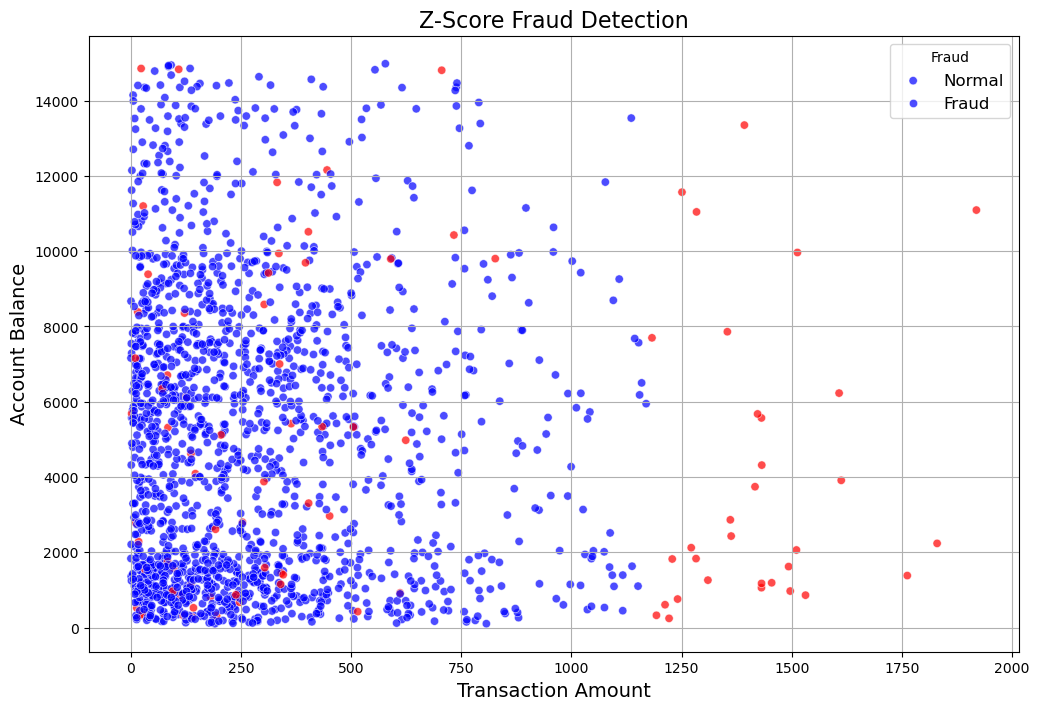

In [21]:
from scipy.stats import zscore


# Define numeric columns
numeric_cols = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']

# Calculate Z-Scores
z_scores = np.abs(zscore(data[numeric_cols]))
data['ZScore_Fraud'] = (z_scores > 3).any(axis=1)  # Flag transactions where any feature exceeds |z| > 3

# Extract fraudulent transactions
zscore_fraud_points = data[data['ZScore_Fraud']]

# Summary of results
total_zscore_fraud_points = data['ZScore_Fraud'].sum()
zscore_fraud_points_summary = zscore_fraud_points[numeric_cols + ['ZScore_Fraud']]

# Adding True values to Fraud column
data['Fraud'] |= data['ZScore_Fraud']

# Scatterplot for Z-Score fraud detection
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['ZScore_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('Z-Score Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

In [22]:
# Save fraudulent transactions detected by Z-Score analysis
# Summary
print(f"Total Fraudulent Transactions Detected by Z-Score Analysis: {total_zscore_fraud_points}")
zscore_fraud_points

Total Fraudulent Transactions Detected by Z-Score Analysis: 92


TransactionID AccountID  TransactionAmount     TransactionDate  \
818       TX001056   AC00317              13.48 2023-09-20 17:49:53   
173       TX000232   AC00430             705.60 2023-02-20 18:41:43   
720       TX000927   AC00224             302.76 2023-11-16 17:14:01   
809       TX001043   AC00246             180.65 2023-12-04 17:54:09   
1530      TX001970   AC00189             146.55 2023-08-03 18:35:54   
...            ...       ...                ...                 ...   
1895      TX002446   AC00439             403.01 2023-09-04 17:32:35   
1705      TX002202   AC00385            1431.54 2023-12-11 16:23:59   
21        TX000033   AC00060             396.45 2023-09-25 16:26:00   
276       TX000357   AC00261             121.82 2023-02-07 17:20:24   
1332      TX001734   AC00108             238.54 2023-04-07 16:04:01   

     TransactionType          Location DeviceID      IP Address MerchantID  \
818            Debit         Las Vegas  D000279    32.169.88.41       M094   
173            Debit           Phoenix  D000103   205.45.234.42       M071   
720            Debit        Sacramento  D000640   221.23.158.87       M043   
809            Debit         Charlotte  D000552   10.223.224.50       M012   
1530           Debit    Virginia Beach  D000163   82.75.200.117       M002   
...              ...               ...      ...             ...        ...   
1895           Debit        Washington  D000677   223.32.70.156       M029   
1705           Debit          Portland  D000490  68.254.244.208       M075   
21             Debit          New York  D000621  133.67.250.163       M007   
276            Debit  Colorado Springs  D000095   186.54.68.246       M094   
1332           Debit      Indianapolis  D000428   83.182.211.68       M006   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
818   Online                   20              3          521.88   
173   Branch                  124              3        14804.70   
720      ATM                   88              3         8583.39   
809   Branch                   38              5          816.01   
1530  Online                  124              5         4087.44   
...      ...                  ...            ...             ...   
1895  Online                  286              3        10513.52   
1705  Online                   84              1         1171.98   
21       ATM                  168              3         9690.15   
276   Online                  123              3         8354.54   
1332     ATM                   12              4          868.91   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
818      2024-11-04 08:10:20               -35475627.0  False               3   
173      2024-11-04 08:09:04               -53789241.0  False               3   
720      2024-11-04 08:11:08               -30553027.0  False               3   
809      2024-11-04 08:09:50               -28995341.0  False               3   
1530     2024-11-04 08:07:38               -39619904.0  False               3   
...                      ...                       ...    ...             ...   
1895     2024-11-04 08:09:32               -36859017.0  False               3   
1705     2024-11-04 08:08:41               -28395882.0  False               1   
21       2024-11-04 08:11:13               -35048713.0  False               3   
276      2024-11-04 08:08:07               -54917263.0  False               3   
1332     2024-11-04 08:07:18               -49824197.0  False               3   

      KMeans_Distance  KMeans_Fraud  ZScore_Fraud  
818          2.704401         False          True  
173          3.444744          True          True  
720          2.033536         False          True  
809          2.456912         False          True  
1530         1.821157         False          True  
...               ...           ...           ...  
1895         3.192753          True          True  
1705     

Flag transactions where any feature exceeds the z-score of 3 standard deviations and updates the Fraud column in data

**Example:**

If a transaction has a TransactionAmount with a Z-Score of 4 (i.e., 4 standard deviations above the mean), it will be flagged as fraud because it significantly deviates from the typical transaction amounts.

### Model 3: Isolation Forest
Highlights anomalous transactions using tree-based partitioning

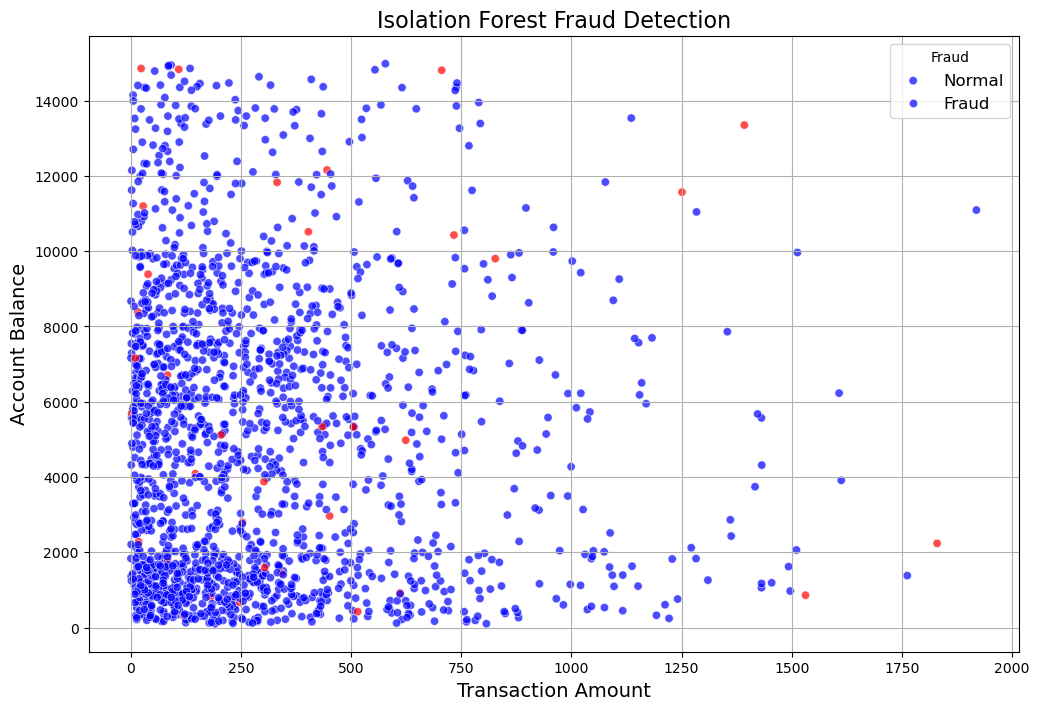

In [23]:
from sklearn.ensemble import IsolationForest
warnings.filterwarnings("ignore", category=FutureWarning)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)  # 2% expected anomalies
iso_forest.fit(numeric_scaled)  # Fit on the scaled numeric data

# Predict anomalies
data['IsoForest_Score'] = iso_forest.decision_function(numeric_scaled)
data['IsoForest_Fraud'] = iso_forest.predict(numeric_scaled) == -1  # Mark anomalies (-1) as fraud

# Extract fraudulent transactions
iso_fraud_points = data[data['IsoForest_Fraud']]

# Summary of Isolation Forest results
total_iso_fraud_points = data['IsoForest_Fraud'].sum()
iso_fraud_points_summary = iso_fraud_points[['TransactionAmount', 'TransactionDuration', 'AccountBalance', 'IsoForest_Fraud']]

# Adding True values to Fraud column
data['Fraud'] |= data['IsoForest_Fraud']

# Scatterplot to visualize fraud points
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['IsoForest_Fraud'],
    palette={True: 'red', False: 'blue'},
    alpha=0.7
)
plt.title('Isolation Forest Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Normal', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()

In [24]:
# Outputs
total_iso_fraud_points, iso_fraud_points_summary.head(), iso_fraud_points_summary.shape

# Save fraudulent transactions detected by Isolation Forest

# Confirm the save location and number of frauds
print(f"Total Fraudulent Transactions Detected (using isolation forest): {total_iso_fraud_points}")
print("Final List of Fraudulent transactions:\n")
iso_fraud_points

Total Fraudulent Transactions Detected (using isolation forest): 35
Final List of Fraudulent transactions:



TransactionID AccountID  TransactionAmount     TransactionDate  \
173       TX000232   AC00430             705.60 2023-02-20 18:41:43   
809       TX001043   AC00246             180.65 2023-12-04 17:54:09   
1530      TX001970   AC00189             146.55 2023-08-03 18:35:54   
700       TX000899   AC00083            1531.31 2023-10-23 18:00:29   
1879      TX002424   AC00340             332.06 2023-06-21 16:38:54   
354       TX000455   AC00264             611.11 2023-10-18 18:32:31   
602       TX000773   AC00093             827.14 2023-01-17 17:25:13   
529       TX000686   AC00071             119.30 2023-08-28 16:08:54   
620       TX000793   AC00468             253.55 2023-01-11 16:56:58   
365       TX000467   AC00063             445.41 2023-11-20 16:27:31   
107       TX000148   AC00161             514.95 2023-04-13 18:37:48   
1673      TX002160   AC00216             624.00 2023-02-16 17:34:34   
1460      TX001885   AC00071             451.31 2023-12-04 16:57:39   
291       TX000376   AC00316            1392.54 2023-11-20 16:51:14   
820       TX001058   AC00191              83.07 2023-01-06 16:13:53   
1752      TX002263   AC00279              15.81 2023-03-02 18:36:55   
260       TX000341   AC00107            1830.00 2023-03-01 16:31:58   
321       TX000415   AC00495              83.50 2023-05-15 18:47:35   
661       TX000851   AC00124              23.40 2023-02-08 18:27:49   
536       TX000694   AC00011             733.29 2023-03-15 18:42:16   
362       TX000464   AC00417             302.16 2023-10-18 17:47:52   
1665      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
1046      TX001364   AC00089             204.70 2023-09-21 16:08:00   
652       TX000838   AC00169              39.21 2023-05-10 16:15:31   
1330      TX001732   AC00333               1.93 2023-10-19 18:06:08   
1559      TX002007   AC00227              28.04 2023-02-15 16:37:09   
1246      TX001619   AC00305             108.75 2023-10-17 16:09:20   
1219      TX001585   AC00358             434.17 2023-01-05 16:40:09   
1675      TX002162   AC00139              10.15 2023-02-23 16:51:34   
16        TX000027   AC00441             246.93 2023-04-17 16:37:01   
883       TX001137   AC00032             341.67 2023-03-06 16:45:24   
384       TX000492   AC00318             505.19 2023-03-14 16:25:04   
870       TX001122   AC00426             303.97 2023-02-02 16:55:25   
1367      TX001775   AC00358              17.79 2023-02-22 17:01:35   
1895      TX002446   AC00439             403.01 2023-09-04 17:32:35   

     TransactionType        Location DeviceID       IP Address MerchantID  \
173            Debit         Phoenix  D000103    205.45.234.42       M071   
809            Debit       Charlotte  D000552    10.223.224.50       M012   
1530           Debit  Virginia Beach  D000163    82.75.200.117       M002   
700            Debit       San Diego  D000319   91.204.200.167       M078   
1879           Debit         Seattle  D000365    94.37.250.128       M086   
354            Debit         Detroit  D000215   141.201.46.191       M045   
602            Debit         El Paso  D000645   215.97.143.157       M018   
529            Debit            Mesa  D000597   90.111.245.138       M058   
620            Debit    Jacksonville  D000112     41.82.55.163       M007   
365            Debit          Fresno  D000039    185.23.87.107       M015   
107            Debit        New York  D000109     23.92.205.75       M056   
1673           Debit         Houston  D000207  113.137.153.101       M097   
1460           Debit      Fort Worth  D000020   68.254.244.208       M046   
291            Debit         El Paso  D000113    63.67.150.226       M013   
820            Debit           Miami  D000182   138.210.196.19       M026   
1752           Debit   Oklahoma City  D000606     96.24.89.146       M018   
260            Debit     San Antonio  D000436    62.27.235.199       M082   
321            Debit          Dallas  D000446    34.92.221.183

**Example:**

If a transaction has unusual values for TransactionAmount and AccountBalance, it will be isolated quickly by the random splits, resulting in a short path length and a high anomaly score. This transaction will be flagged as fraud.

### Logistic Regression
Classifies transactions as fraud or non-fraud using supervised learning.

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       497
        True       1.00      0.89      0.94        28

    accuracy                           0.99       525
   macro avg       1.00      0.95      0.97       525
weighted avg       0.99      0.99      0.99       525



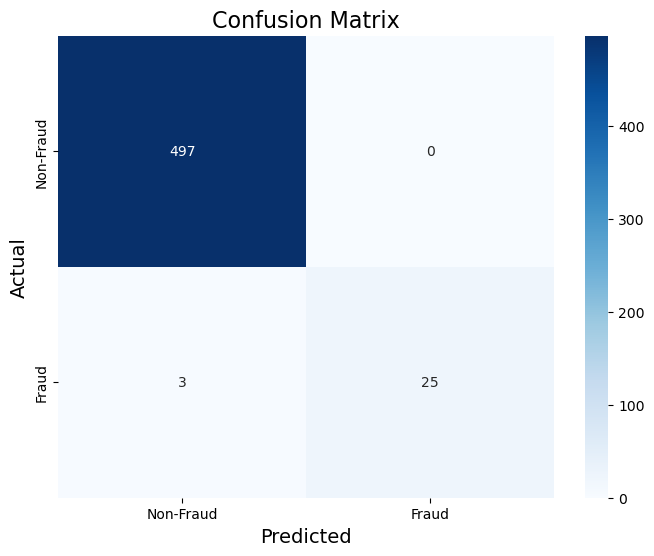

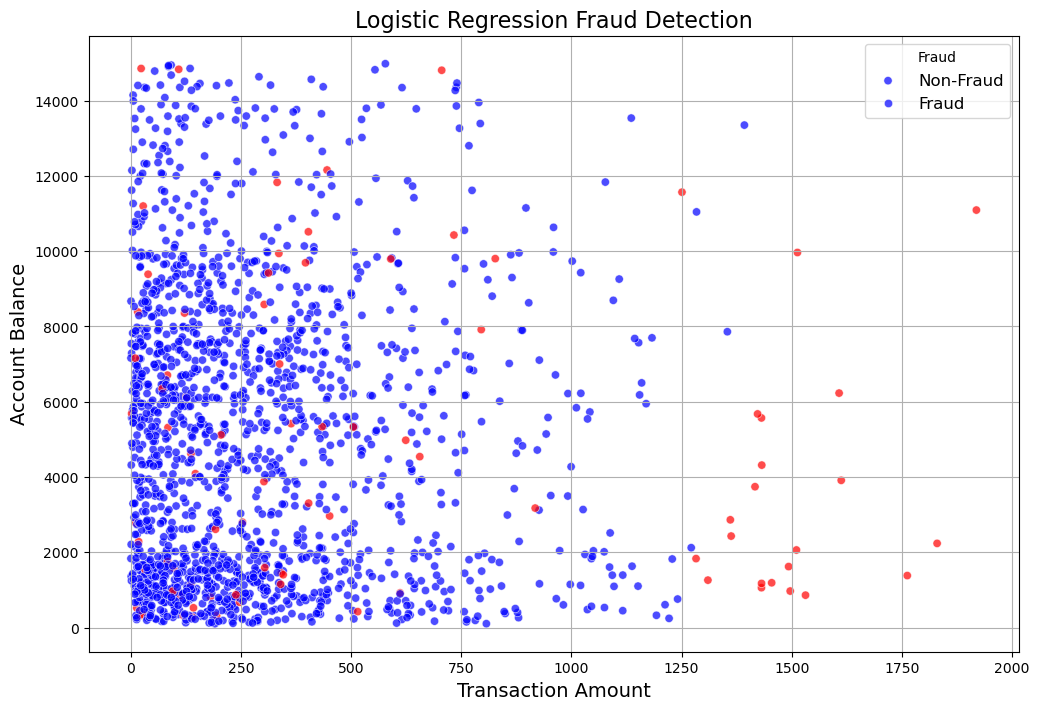

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Define relevant columns for logistic regression
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
target = 'Fraud'

# Prepare the dataset
X = data[features]
y = data[target]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict fraud on the test set
y_pred = log_reg.predict(X_test)


# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

# Add predictions to the dataset
data['LogReg_Fraud'] = log_reg.predict(X_scaled)
data['Fraud'] |= data['LogReg_Fraud']

# Visualize fraud vs. non-fraud transactions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=data['TransactionAmount'],
    y=data['AccountBalance'],
    hue=data['LogReg_Fraud'],
    palette={1: 'red', 0: 'blue'},
    alpha=0.7
)
plt.title('Logistic Regression Fraud Detection', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', labels=['Non-Fraud', 'Fraud'], fontsize=12)
plt.grid(True)
plt.show()


In [26]:
# Save fraudulent transactions detected by Logistic Regression
log_reg_fraud_points = data[data['LogReg_Fraud'] == 1]

# Summary
total_log_reg_fraud_points = log_reg_fraud_points.shape[0]
print(f"Total Fraudulent Transactions Detected by Logistic Regression: {total_log_reg_fraud_points}")
log_reg_fraud_points

Total Fraudulent Transactions Detected by Logistic Regression: 85


TransactionID AccountID  TransactionAmount     TransactionDate  \
818       TX001056   AC00317              13.48 2023-09-20 17:49:53   
173       TX000232   AC00430             705.60 2023-02-20 18:41:43   
720       TX000927   AC00224             302.76 2023-11-16 17:14:01   
809       TX001043   AC00246             180.65 2023-12-04 17:54:09   
1530      TX001970   AC00189             146.55 2023-08-03 18:35:54   
...            ...       ...                ...                 ...   
1895      TX002446   AC00439             403.01 2023-09-04 17:32:35   
1705      TX002202   AC00385            1431.54 2023-12-11 16:23:59   
21        TX000033   AC00060             396.45 2023-09-25 16:26:00   
276       TX000357   AC00261             121.82 2023-02-07 17:20:24   
1332      TX001734   AC00108             238.54 2023-04-07 16:04:01   

     TransactionType          Location DeviceID      IP Address MerchantID  \
818            Debit         Las Vegas  D000279    32.169.88.41       M094   
173            Debit           Phoenix  D000103   205.45.234.42       M071   
720            Debit        Sacramento  D000640   221.23.158.87       M043   
809            Debit         Charlotte  D000552   10.223.224.50       M012   
1530           Debit    Virginia Beach  D000163   82.75.200.117       M002   
...              ...               ...      ...             ...        ...   
1895           Debit        Washington  D000677   223.32.70.156       M029   
1705           Debit          Portland  D000490  68.254.244.208       M075   
21             Debit          New York  D000621  133.67.250.163       M007   
276            Debit  Colorado Springs  D000095   186.54.68.246       M094   
1332           Debit      Indianapolis  D000428   83.182.211.68       M006   

     Channel  ...  PreviousTransactionDate  TimeSinceLastTransaction  Fraud  \
818   Online  ...      2024-11-04 08:10:20               -35475627.0   True   
173   Branch  ...      2024-11-04 08:09:04               -53789241.0   True   
720      ATM  ...      2024-11-04 08:11:08               -30553027.0   True   
809   Branch  ...      2024-11-04 08:09:50               -28995341.0   True   
1530  Online  ...      2024-11-04 08:07:38               -39619904.0   True   
...      ...  ...                      ...                       ...    ...   
1895  Online  ...      2024-11-04 08:09:32               -36859017.0   True   
1705  Online  ...      2024-11-04 08:08:41               -28395882.0   True   
21       ATM  ...      2024-11-04 08:11:13               -35048713.0   True   
276   Online  ...      2024-11-04 08:08:07               -54917263.0   True   
1332     ATM  ...      2024-11-04 08:07:18               -49824197.0   True   

     KMeans_Cluster  KMeans_Distance  KMeans_Fraud  ZScore_Fraud  \
818               3         2.704401         False          True   
173               3         3.444744          True          True   
720               3         2.033536         False          True   
809               3         2.456912         False          True   
1530              3         1.821157         False          True   
...             ...              ...           ...           ...   
1895              3         3.192753          True          True   
1705              1         2.195546         False          True   
21                3         2.227695         False          True   
276               3         1.963936         False          True   
1332              3         1.974542         False          True   

      IsoForest_Score  IsoForest_Fraud  LogReg_Fraud  
818          0.027701            False          True  
173         -0.021348             True          True  
720          0.037648            False          True  
809         -0.018146             True          True  
1530        -0.025420             True          True  
...               ...              ...           ...  
1895        -0.023481             True          True  
1705     

#### **The column "fraud" is finalized using un-supervised learning methods on numerical features from the dataset.**

#### Now, we assign threat level to each suspicious transaction based on overlapping fraud values obtained from running each fraud analysis statistical test.

Total Fraudulent Transactions Detected: 95


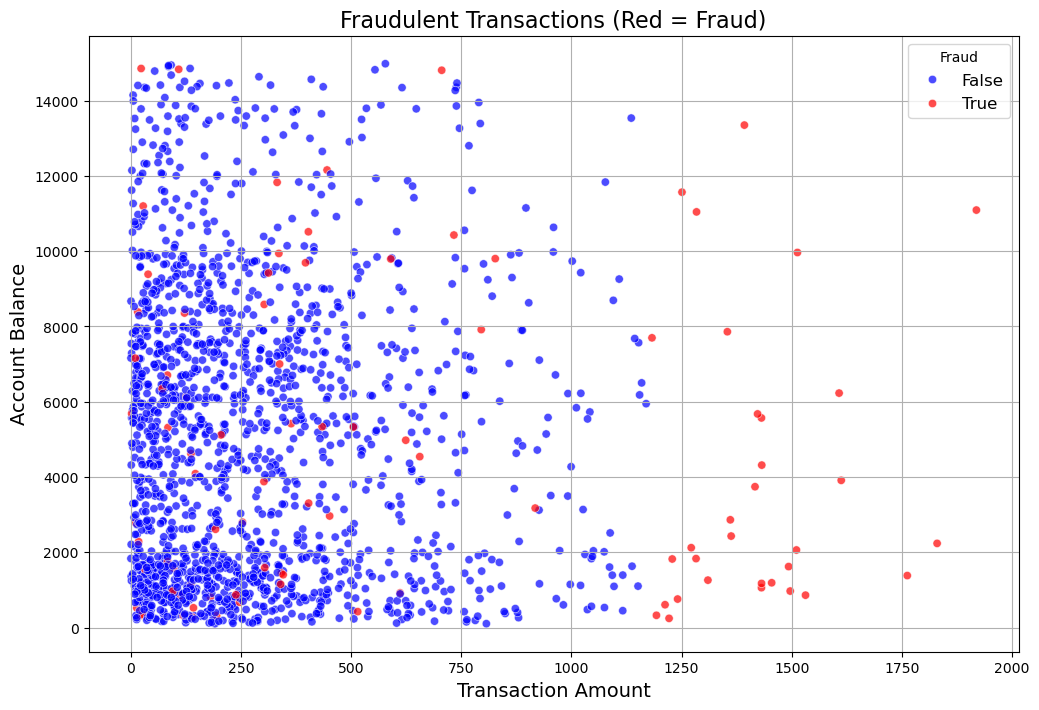

Results saved to /Users/raghav/Downloads/fraud_detection_results.csv


TransactionID AccountID  TransactionAmount     TransactionDate  \
818       TX001056   AC00317              13.48 2023-09-20 17:49:53   
173       TX000232   AC00430             705.60 2023-02-20 18:41:43   
720       TX000927   AC00224             302.76 2023-11-16 17:14:01   
809       TX001043   AC00246             180.65 2023-12-04 17:54:09   
1530      TX001970   AC00189             146.55 2023-08-03 18:35:54   
...            ...       ...                ...                 ...   
1895      TX002446   AC00439             403.01 2023-09-04 17:32:35   
1705      TX002202   AC00385            1431.54 2023-12-11 16:23:59   
21        TX000033   AC00060             396.45 2023-09-25 16:26:00   
276       TX000357   AC00261             121.82 2023-02-07 17:20:24   
1332      TX001734   AC00108             238.54 2023-04-07 16:04:01   

     TransactionType          Location DeviceID      IP Address MerchantID  \
818            Debit         Las Vegas  D000279    32.169.88.41       M094   
173            Debit           Phoenix  D000103   205.45.234.42       M071   
720            Debit        Sacramento  D000640   221.23.158.87       M043   
809            Debit         Charlotte  D000552   10.223.224.50       M012   
1530           Debit    Virginia Beach  D000163   82.75.200.117       M002   
...              ...               ...      ...             ...        ...   
1895           Debit        Washington  D000677   223.32.70.156       M029   
1705           Debit          Portland  D000490  68.254.244.208       M075   
21             Debit          New York  D000621  133.67.250.163       M007   
276            Debit  Colorado Springs  D000095   186.54.68.246       M094   
1332           Debit      Indianapolis  D000428   83.182.211.68       M006   

     Channel  ...  PreviousTransactionDate  TimeSinceLastTransaction  Fraud  \
818   Online  ...      2024-11-04 08:10:20               -35475627.0   True   
173   Branch  ...      2024-11-04 08:09:04               -53789241.0   True   
720      ATM  ...      2024-11-04 08:11:08               -30553027.0   True   
809   Branch  ...      2024-11-04 08:09:50               -28995341.0   True   
1530  Online  ...      2024-11-04 08:07:38               -39619904.0   True   
...      ...  ...                      ...                       ...    ...   
1895  Online  ...      2024-11-04 08:09:32               -36859017.0   True   
1705  Online  ...      2024-11-04 08:08:41               -28395882.0   True   
21       ATM  ...      2024-11-04 08:11:13               -35048713.0   True   
276   Online  ...      2024-11-04 08:08:07               -54917263.0   True   
1332     ATM  ...      2024-11-04 08:07:18               -49824197.0   True   

     KMeans_Cluster  KMeans_Distance  KMeans_Fraud  ZScore_Fraud  \
818               3         2.704401         False          True   
173               3         3.444744          True          True   
720               3         2.033536         False          True   
809               3         2.456912         False          True   
1530              3         1.821157         False          True   
...             ...              ...           ...           ...   
1895              3         3.192753          True          True   
1705              1         2.195546         False          True   
21                3         2.227695         False          True   
276               3         1.963936         False          True   
1332              3         1.974542         False          True   

      IsoForest_Score  IsoForest_Fraud  LogReg_Fraud  
818          0.027701            False          True  
173         -0.021348             True          True  
720          0.037648            False          True  
809         -0.018146             True          True  
1530        -0.025420             True          True  
...               ...              ...           ...  
1895        -0.023481             True          True  
1705     

In [27]:
# Summary of fraud detection results
print(f"Total Fraudulent Transactions Detected: {data['Fraud'].sum()}")

# Visualize fraudulent transactions
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TransactionAmount', 
    y='AccountBalance', 
    hue='Fraud', 
    data=data, 
    palette={True: 'red', False: 'blue'}, 
    alpha=0.7
)
plt.title('Fraudulent Transactions (Red = Fraud)', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=14)
plt.ylabel('Account Balance', fontsize=14)
plt.legend(title='Fraud', fontsize=12)
plt.grid(True)
plt.show()

# Save the results to a CSV file
output_path = '/Users/raghav/Downloads/fraud_detection_results.csv'
data.to_csv(output_path, index=False)
print(f"Results saved to {output_path}")

# Filter the DataFrame for rows where 'Fraud' is True
fraud_rows = data[data['Fraud'] == True]

# Print the filtered rows
fraud_rows

In [33]:
# Identify boolean columns
boolean_columns = fraud_rows.select_dtypes(include=['bool']).columns
fraud_rows = fraud_rows.copy()

# Count the number of True values per row
fraud_rows['Threat_Level'] = fraud_rows[boolean_columns].sum(axis=1)-1

# Sort rows by the count of True values in descending order
sorted_data = fraud_rows.sort_values(by='Threat_Level', ascending=False)
metric_columns = ['KMeans_Cluster',	'KMeans_Distance',	'KMeans_Fraud',	'ZScore_Fraud',	'IsoForest_Score',	'IsoForest_Fraud',	'LogReg_Fraud']
sorted_data = sorted_data.drop(columns=metric_columns, errors='ignore')
# Save the sorted data to a new CSV file
output_path = '/Users/raghav/Desktop/Apexon/DC_fraud_Detection/potential_fraudulent_transactions1.csv'
sorted_data.to_csv(output_path, index=False)
print(f"Sorted data saved to {output_path}")

# Load the dataset
fraud_file_path = '/Users/raghav/Desktop/Apexon/DC_fraud_Detection/potential_fraudulent_transactions1.csv'  # Replace with your file path
fr = pd.read_csv(fraud_file_path)

# Display the top rows
print("Top rows with the most True values:")
sorted_data

Sorted data saved to /Users/raghav/Desktop/Apexon/DC_fraud_Detection/potential_fraudulent_transactions1.csv
Top rows with the most True values:


TransactionID AccountID  TransactionAmount     TransactionDate  \
1895      TX002446   AC00439             403.01 2023-09-04 17:32:35   
365       TX000467   AC00063             445.41 2023-11-20 16:27:31   
1665      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
173       TX000232   AC00430             705.60 2023-02-20 18:41:43   
602       TX000773   AC00093             827.14 2023-01-17 17:25:13   
...            ...       ...                ...                 ...   
232       TX000312   AC00285            1221.65 2023-09-27 16:55:35   
264       TX000345   AC00156            1271.90 2023-08-28 16:43:15   
52        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
1156      TX001498   AC00018            1228.81 2023-02-20 16:36:36   
1313      TX001707   AC00048            1283.97 2023-08-09 17:32:04   

     TransactionType          Location DeviceID      IP Address MerchantID  \
1895           Debit        Washington  D000677   223.32.70.156       M029   
365            Debit            Fresno  D000039   185.23.87.107       M015   
1665           Debit          Columbus  D000282     35.67.21.23       M054   
173            Debit           Phoenix  D000103   205.45.234.42       M071   
602            Debit           El Paso  D000645  215.97.143.157       M018   
...              ...               ...      ...             ...        ...   
232            Debit            Denver  D000098  83.207.115.164       M091   
264            Debit           Houston  D000312  210.136.14.108       M073   
52             Debit      Indianapolis  D000231    193.83.0.183       M036   
1156           Debit     San Francisco  D000381   63.191.171.41       M034   
1313           Debit  Colorado Springs  D000340    4.134.78.167       M030   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
1895  Online                  286              3        10513.52   
365      ATM                  235              3        12154.66   
1665     ATM                  107              2        11565.97   
173   Branch                  124              3        14804.70   
602   Branch                  265              4         9800.21   
...      ...                  ...            ...             ...   
232   Online                  153              1          243.92   
264      ATM                  155              1         2120.80   
52    Branch                   24              1          605.95   
1156     ATM                  254              1         1821.00   
1313     ATM                  121              1        11041.90   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  Threat_Level  
1895     2024-11-04 08:09:32               -36859017.0   True             4  
365      2024-11-04 08:08:08               -30210037.0   True             4  
1665     2024-11-04 08:08:33               -53101407.0   True             4  
173      2024-11-04 08:09:04               -53789241.0   True             4  
602      2024-11-04 08:08:14               -56731381.0   True             4  
...                      ...                       ...    ...           ...  
232      2024-11-04 08:10:41               -34874106.0   True             1  
264      2024-11-04 08:09:27               -37466772.0   True             1  
52       2024-11-04 08:06:51               -34270222.0   True             1  
1156     2024-11-04 08:09:05               -53796749.0   True             1  
1313     2024-11-04 08:07:52               -39105348.0   True             1  

[95 rows x 17 columns]

# FINAL OUTPUT: potential_fraudulent_transactions.csv gives a List of Fraudulent Transactions in the order of their Threat Level. 

Result shows 119/1944 transactions are fraudulent

#### Displaying the top 5 AccountIDs with most number of potential fraud transactions

In [33]:
# Count occurrences of each AccountID
accountid_counts = fr['AccountID'].value_counts()

# Find the most repeated AccountID(s)
most_repeated_accountid = accountid_counts.idxmax()
max_count = accountid_counts.max()

# Display the top repeated AccountID(s)
print(f"The most repeated AccountID is: {most_repeated_accountid} with {max_count} occurrences.")

# Display the top 5 most repeated AccountIDs
print("Top 5 most repeated AccountIDs:")
print(accountid_counts.head())

The most repeated AccountID is: AC00358 with 3 occurrences.
Top 5 most repeated AccountIDs:
AccountID
AC00358    3
AC00272    2
AC00161    2
AC00200    1
AC00312    1
Name: count, dtype: int64


#### Threat Chart

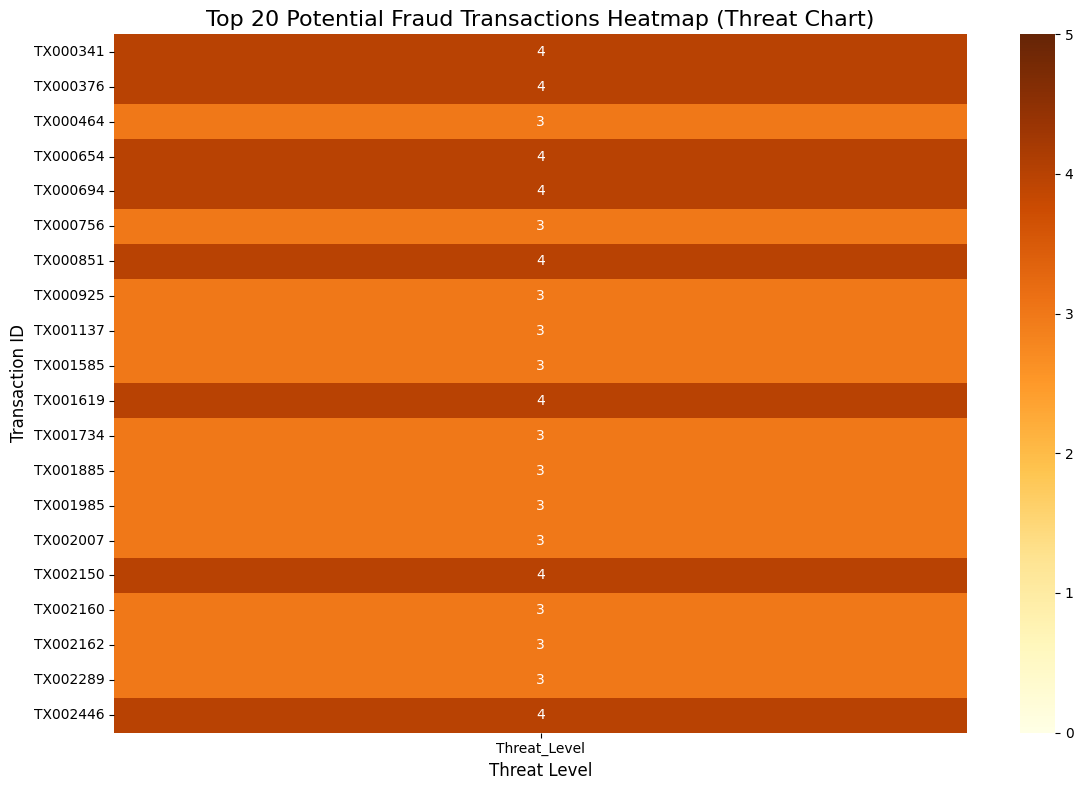

In [34]:
# Select the top 20 rows
top_20_data = fr.head(20)

# Pivot table for heatmap
heatmap_data = top_20_data.pivot_table(
    index='TransactionID', 
    values='Threat_Level'
)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data, 
    annot=True,
    cmap="YlOrBr",
    vmin=0,
    vmax=5, 
    cbar=True
)

# Add labels and title
plt.title("Top 20 Potential Fraud Transactions Heatmap (Threat Chart)", fontsize=16)
plt.xlabel("Threat Level", fontsize=12)
plt.ylabel("Transaction ID", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

The fraud detection project successfully combines statistical and machine learning techniques to identify potential debit card fraudulent transactions in a dataset of 1944 records. Through thorough data preprocessing and comprehensive analyses, five anomaly detection methods—K-Means Clustering, Z-Score Analysis, Logistic Regression, and Isolation Forest—were implemented, each contributing unique insights. The results were consolidated into a ThreatLevel metric, enabling a prioritized view of high-risk transactions.

The project not only demonstrates effective detection but also emphasizes interpretability through detailed visualizations and color-coded threat chart. With scalability and practical applicability, this framework can serve as a robust foundation for real-world fraud detection systems for our clients in the finance sector.

Check 'potential_fraudulent_transactions.csv' for the list of suspicious transactions that are flagged

# Clarity on the data being used and produced:

In [43]:
output_path = '/Users/raghav/Downloads/debit_card_transactions_.csv'
sorted_data.to_csv(output_path, index=False)
print("Here is the training data for the Debit Card Fraud Detection Model: \n")
data

Here is the training data for the Debit Card Fraud Detection Model: 



TransactionID AccountID  TransactionAmount     TransactionDate  \
2297      TX002298   AC00219             111.41 2023-12-27 17:18:17   
1511      TX001512   AC00345             288.43 2023-05-08 16:37:53   
2267      TX002268   AC00416            1360.67 2023-04-19 16:38:41   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
1556      TX001557   AC00470             170.97 2023-05-01 17:04:30   
...            ...       ...                ...                 ...   
1660      TX001661   AC00459             285.69 2023-12-06 18:15:42   
295       TX000296   AC00272              20.54 2023-08-21 18:09:24   
916       TX000917   AC00272             337.73 2023-05-23 17:12:39   
513       TX000514   AC00469              65.57 2023-04-06 17:24:16   
2392      TX002393   AC00345             429.25 2023-06-12 16:26:36   

     TransactionType      Location DeviceID       IP Address MerchantID  \
2297           Debit       Chicago  D000162    18.72.115.111       M079   
1511           Debit       Phoenix  D000136     7.105.184.86       M075   
2267           Debit       Raleigh  D000017   164.75.163.220       M092   
74             Debit  Indianapolis  D000231     193.83.0.183       M036   
1556           Debit     Nashville  D000259    187.52.200.18       M044   
...              ...           ...      ...              ...        ...   
1660           Debit         Miami  D000132    141.169.67.34       M064   
295            Debit    Fort Worth  D000348   171.101.134.74       M055   
916            Debit   San Antonio  D000480  219.193.239.152       M065   
513            Debit         Miami  D000649     1.198.76.182       M039   
2392           Debit       Seattle  D000199    199.6.127.153       M090   

     Channel  ...  PreviousTransactionDate  TimeSinceLastTransaction  Fraud  \
2297  Branch  ...      2024-11-04 08:10:44               -27010347.0  False   
1511  Branch  ...      2024-11-04 08:09:00               -47143867.0  False   
2267  Branch  ...      2024-11-04 08:06:27               -48785266.0   True   
74    Branch  ...      2024-11-04 08:06:51               -34270222.0   True   
1556  Branch  ...      2024-11-04 08:07:51               -47747001.0  False   
...      ...  ...                      ...                       ...    ...   
1660     ATM  ...      2024-11-04 08:07:59               -28821137.0  False   
295   Branch  ...      2024-11-04 08:07:28               -38066284.0  False   
916   Online  ...      2024-11-04 08:07:28               -45845689.0   True   
513   Online  ...      2024-11-04 08:06:26               -49905730.0  False   
2392  Online  ...      2024-11-04 08:08:36               -44120520.0  False   

     KMeans_Cluster  KMeans_Distance  KMeans_Fraud  ZScore_Fraud  \
2297              0         1.060901         False         False   
1511              1         0.736206         False         False   
2267              4         1.731135         False          True   
74                4         1.968959         False          True   
1556              0         1.310280         False         False   
...             ...              ...           ...           ...   
1660              1         0.817173         False         False   
295               1         0.991868         False         False   
916               2         0.676190         False          True   
513               3         0.700987         False         False   
2392              1         1.140062         False         False   

      IsoForest_Score  IsoForest_Fraud  LogReg_Fraud  
2297         0.225824            False         False  
1511         0.244980            False         False  
2267         0.058479            False          True  
74           0.048990            False         False  
1556         0.135291            False         False  
...               ...              ...           ...  
1660         0.222054            False         False  
295          0.235281            False       

In [44]:
output_path = '/Users/raghav/Downloads/potential_fraudulent_transactions_.csv'
sorted_data.to_csv(output_path, index=False)

print("Here are the results for the Debit Card Fraud Detection Model: \n")
sorted_data

Here are the results for the Debit Card Fraud Detection Model: 



TransactionID AccountID  TransactionAmount     TransactionDate  \
2149      TX002150   AC00110            1250.94 2023-02-28 17:45:06   
1618      TX001619   AC00305             108.75 2023-10-17 16:09:20   
693       TX000694   AC00011             733.29 2023-03-15 18:42:16   
850       TX000851   AC00124              23.40 2023-02-08 18:27:49   
2445      TX002446   AC00439             403.01 2023-09-04 17:32:35   
...            ...       ...                ...                 ...   
535       TX000536   AC00161            1182.86 2023-12-11 16:06:51   
1156      TX001157   AC00211             917.81 2023-08-30 18:38:56   
2086      TX002087   AC00029            1192.95 2023-12-04 18:30:00   
1514      TX001515   AC00272              71.34 2023-08-28 16:00:00   
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   

     TransactionType        Location DeviceID       IP Address MerchantID  \
2149           Debit        Columbus  D000282      35.67.21.23       M054   
1618           Debit         Houston  D000081  119.163.214.161       M097   
693            Debit  Virginia Beach  D000618    16.51.235.240       M032   
850            Debit         El Paso  D000079     74.58.165.67       M027   
2445           Debit      Washington  D000677    223.32.70.156       M029   
...              ...             ...      ...              ...        ...   
535            Debit          Tucson  D000673     96.24.89.146       M050   
1156           Debit     Kansas City  D000217     42.61.10.112       M047   
2086           Debit       Las Vegas  D000227    71.93.189.160       M068   
1514           Debit           Miami  D000256   188.225.207.71       M021   
74             Debit    Indianapolis  D000231     193.83.0.183       M036   

     Channel  ...  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
2149     ATM  ...               -53101407.0   True               4   
1618     ATM  ...               -33148858.0   True               2   
693      ATM  ...               -51801896.0   True               2   
850      ATM  ...               -54826765.0   True               2   
2445  Online  ...               -36859017.0   True               2   
...      ...  ...                       ...    ...             ...   
535   Online  ...               -28396927.0   True               4   
1156     ATM  ...               -37287050.0   True               4   
2086  Branch  ...               -28993081.0   True               4   
1514  Online  ...               -37469383.0   True               2   
74    Branch  ...               -34270222.0   True               4   

     KMeans_Distance  KMeans_Fraud  ZScore_Fraud  IsoForest_Score  \
2149        3.015050          True          True        -0.009762   
1618        2.938793          True          True        -0.052786   
693         2.851417          True          True        -0.066338   
850         2.687701          True          True        -0.052953   
2445        3.311445          True          True        -0.038969   
...              ...           ...           ...              ...   
535         1.870734         False          True         0.070057   
1156        1.950436         False         False         0.054832   
2086        1.594830         False          True         0.088135   
1514        2.057516         False          True         0.043861   
74          1.968959         False          True         0.048990   

      IsoForest_Fraud  LogReg_Fraud  Threat_Level  
2149             True          True             4  
1618             True          True             4  
693              True          True             4  
850              True          True             4  
2445             True          True             4  
...               ...           ...           ...  
535             False         False             1  
1156            False          True             1  
2086            False         False             1  
1514            False         False  

In [45]:
output_path = '/Users/raghav/Downloads/debit_card_transactions_test_data_.csv'
sorted_data.to_csv(output_path, index=False)
print("Here is the test dataset for the Debit Card Fraud Detection Model: \n")
test_data

Here is the test dataset for the Debit Card Fraud Detection Model: 



TransactionID AccountID  TransactionAmount     TransactionDate  \
1324      TX001325   AC00482             686.17 2023-10-03 17:27:25   
397       TX000398   AC00293             131.46 2023-05-15 16:37:12   
472       TX000473   AC00213             423.11 2023-07-25 18:41:02   
178       TX000179   AC00156             237.06 2023-12-18 16:47:17   
55        TX000056   AC00374             316.95 2023-08-04 17:53:40   
...            ...       ...                ...                 ...   
707       TX000708   AC00442             210.45 2023-12-11 16:47:05   
2379      TX002380   AC00443             684.50 2023-07-31 18:52:14   
499       TX000500   AC00325             157.97 2023-06-21 16:00:51   
824       TX000825   AC00319              60.99 2023-08-01 17:14:17   
888       TX000889   AC00176               1.21 2023-08-21 17:19:06   

     TransactionType       Location DeviceID      IP Address MerchantID  \
1324           Debit         Denver  D000103  199.199.60.222       M030   
397            Debit      Charlotte  D000287   146.69.70.214       M006   
472            Debit       Columbus  D000113    64.57.44.102       M055   
178            Debit        Phoenix  D000455    61.95.76.233       M049   
55             Debit           Mesa  D000013   81.102.230.41       M052   
...              ...            ...      ...             ...        ...   
707            Debit      Las Vegas  D000547  144.91.150.133       M011   
2379           Debit     Fort Worth  D000075   190.251.45.32       M035   
499            Debit   Philadelphia  D000635   89.237.88.251       M009   
824            Debit  Oklahoma City  D000651    5.50.152.168       M037   
888            Debit        Atlanta  D000369   96.115.67.230       M039   

     Channel  TransactionDuration  LoginAttempts  AccountBalance  \
1324     ATM                   96              1         2246.15   
397   Branch                  258              1         6642.33   
472      ATM                   47              1          412.78   
178   Online                   46              1         1182.77   
55    Branch                   83              1         1324.03   
...      ...                  ...            ...             ...   
707      ATM                  146              1         1242.49   
2379  Branch                   76              1         6258.63   
499   Branch                  140              1         5529.92   
824   Branch                   58              1         7281.46   
888   Branch                  196              1         7542.74   

     PreviousTransactionDate  TimeSinceLastTransaction  Fraud  KMeans_Cluster  \
1324     2024-11-04 08:07:37               -34353612.0  False               3   
397      2024-11-04 08:11:30               -46539258.0  False               0   
472      2024-11-04 08:10:58               -40397396.0  False               4   
178      2024-11-04 08:07:50               -27789633.0  False               4   
55       2024-11-04 08:09:15               -39536135.0  False               4   
...                      ...                       ...    ...             ...   
707      2024-11-04 08:06:24               -28394359.0  False               4   
2379     2024-11-04 08:10:14               -39878280.0  False               3   
499      2024-11-04 08:10:06               -43344555.0  False               4   
824      2024-11-04 08:07:51               -39797614.0  False               1   
888      2024-11-04 08:11:34               -38069548.0  False               0   

      KMeans_Distance  KMeans_Fraud  
1324         0.846230         False  
397          0.897647         False  
472          1.093060         False  
178          0.647288         False  
55           0.531340         False  
...               ...           ...  
707          0.936325         False  
2379         1.057741         False  
499          1.130359         False  
824          0.929811         False  
888          1.170859         False  

[156

# TESTING:

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.91      0.96        47
        True       0.00      0.00      0.00         0

    accuracy                           0.91        47
   macro avg       0.50      0.46      0.48        47
weighted avg       1.00      0.91      0.96        47



/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/raghav/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


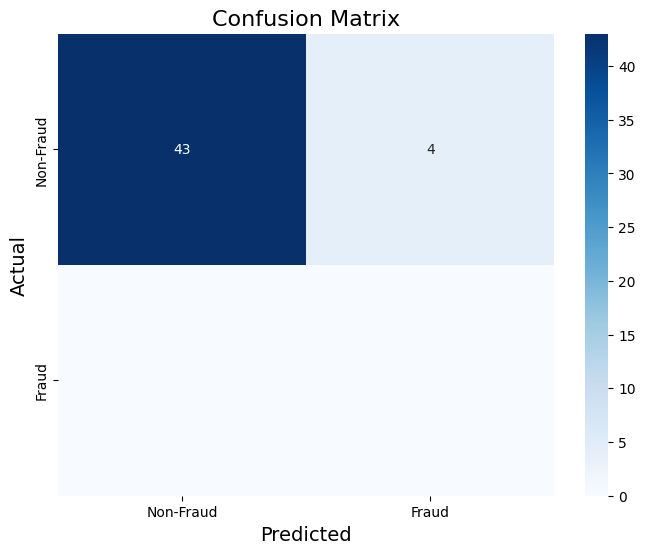

In [47]:
test_data
features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
target = 'Fraud'

# Prepare the dataset
X1 = test_data[features]
y1 = test_data[target]

# Standardize the features
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Split the dataset into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.3, random_state=42)

y1_pred = log_reg.predict(X1_test)


# Evaluate model performance
print("Classification Report:")
print(classification_report(y1_test, y1_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y1_test, y1_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()